In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import blobfile as bf
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformer_lens import HookedTransformer
from typing import Any
from copy import deepcopy
from IPython.display import Markdown, display

from torch import nn
from einops import rearrange
import numpy as np
import plotly.express as px
from pathlib import Path
from torch.utils.data import Subset
import plotly.graph_objects as go
import json
from cupbearer import utils, data, detectors, tasks, models, scripts

In [3]:
os.environ["NO_GCE_CHECK"] = "true"

In [41]:
list(bf.listdir("gs://arc-ml-public/distinctions/datasets"))

['camel_task.json', 'hex_task.json', 'ifelse_task.json', 'indent_task.json']

In [42]:
with bf.BlobFile("gs://arc-ml-public/distinctions/datasets/hex_task.json") as f:
    task_config = json.load(f)

In [47]:
task.model.tokenizer.decode(task_config["effect_tokens"])

'0123456789abcdefedacadceabfeccffacedecedadeefecbeeaddadeffaceddeeaddebafcdacedceedaffadabedbfaeaccdeedbbdeddfdbaabacafeefacfadedafedecffffabbfdedefabacbeffdcabebecbcfceededebadeabdedafbededececcafeedccccabcacaaceaecadfedffffffffaddedfffaaaaabadaffedebfefedeadbeccaaedafacfacedbeecccfabdbcecaafaaaafffffffefefebabfadeebaffedadaceadeefebeeeeaeabbeaaaaaaaaceeded'

In [7]:
model = HookedTransformer.from_pretrained(
    "attn-only-1l",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    move_to_device=False,
    fold_value_biases=False,
).to("mps")
with bf.BlobFile("gs://arc-ml-public/distinctions/models/main.pth", "rb") as fh:
    state_dict = torch.load(fh, map_location="mps")
    state_dict["unembed.b_U"] = model.unembed.b_U
model.load_state_dict(state_dict)

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


<All keys matched successfully>

In [67]:
idx = 0
print(model.tokenizer.decode(task_config["test_anomalous"][idx]["prefix_tokens"]))
print(model.tokenizer.decode(task_config["test_anomalous"][idx]["completion_token"]))

)
    signature = 'D->D' if isComplexType(t)
 else


In [34]:
task_config["train"][0]["prefix_tokens"]

[507, 426, 15313, 16, 70, 9485, 10, 647, 543, 90, 65, 75, 603, 261, 65, 75]

In [33]:
all(
    len(task_config["train"][i]["prefix_tokens"]) == 16
    for i in range(len(task_config["train"]))
)

True

In [4]:
class ARCDataset(torch.utils.data.Dataset):
    def __init__(self, data: list[dict[str, Any]]):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the list to a tensor to make sure that pytorch's default collate_fn
        # batches the lists into a single tensor (TransformerLens requires that).
        # Note that all sequences have the same length in these datasets.
        return torch.tensor(
            self.data[idx]["prefix_tokens"], dtype=torch.long
        ), self.data[idx]["completion_token"]

In [5]:
def arc_task(name: str, device: str):
    model = HookedTransformer.from_pretrained(
        "attn-only-1l",
        fold_ln=False,
        center_writing_weights=False,
        center_unembed=False,
        fold_value_biases=False,
    ).to(device)

    cache_path = Path(".cupbearer_cache/arc/main.pth")

    directory = cache_path.parent
    directory.mkdir(parents=True, exist_ok=True)

    if cache_path.exists():
        state_dict = torch.load(cache_path, map_location=device)
    else:
        # `model_path` seems to have a type, uses a `.path` extension instead of `.pth`
        # with bf.BlobFile(task_data["model_path"], "rb") as fh:
        with bf.BlobFile("gs://arc-ml-public/distinctions/models/main.pth", "rb") as fh:
            state_dict = torch.load(fh, map_location=device)
        state_dict["unembed.b_U"] = model.unembed.b_U
        torch.save(state_dict, cache_path)

    model.load_state_dict(state_dict)

    cache_path = Path(f".cupbearer_cache/arc/{name}_task.json")
    if cache_path.exists():
        with cache_path.open("r") as f:
            task_data = json.load(f)
    else:
        path = f"gs://arc-ml-public/distinctions/datasets/{name}_task.json"
        with bf.BlobFile(path) as f:
            task_data = json.load(f)
        with cache_path.open("w") as f:
            json.dump(task_data, f)

    train_data = ARCDataset(task_data["train"])
    normal_test_data = ARCDataset(task_data["test_non_anomalous"])
    anomalous_test_data = ARCDataset(task_data["test_anomalous"])

    return tasks.Task.from_separate_data(
        model=model,
        trusted_data=train_data,
        clean_test_data=normal_test_data,
        anomalous_test_data=anomalous_test_data,
    )

In [20]:
task = arc_task("hex", "mps")

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


In [31]:
def get_activation_at_last_token(
    activation: torch.Tensor, inputs: list[list[int]], name: str
):
    if activation.ndim == 3:
        # Residual stream or equivalent, shape is (batch, seq, hidden)
        return activation[:, -1, :]
    elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
        # Attention, shape is (batch, num_heads, query, key)
        return activation[:, :, -1, :].reshape(activation.shape[0], -1)
    elif activation.ndim == 4:
        # Query/key/value, shape is (batch, seq, num_heads, hidden)
        return activation[:, -1, :, :].reshape(activation.shape[0], -1)
    else:
        raise ValueError(f"Unexpected activation shape: {activation.shape}")

In [37]:
names = [
    "hook_embed.output",
    # "blocks.0.hook_attn_out.output",
    # "blocks.0.attn.hook_attn_scores.output",
    # "blocks.0.attn.hook_q.output",
    # "ln_final.hook_normalized.output",
]

detector = detectors.MahalanobisDetector(names, layer_aggregation="mean")

In [22]:
for name, _ in task.model.named_modules():
    print(name)


embed
hook_embed
pos_embed
hook_pos_embed
blocks
blocks.0
blocks.0.ln1
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.attn
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_post
ln_final
ln_final.hook_scale
ln_final.hook_normalized
unembed


100%|██████████| 256/256 [00:01<00:00, 166.97it/s]


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-04-27 15:32:43.788 | INFO     | cupbearer.detectors.anomaly_detector:eval:149 - AUC_ROC (all): 0.7204
2024-04-27 15:32:43.788 | INFO     | cupbearer.detectors.anomaly_detector:eval:150 - AP (all): 0.6272


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.7204084396362305,
               'AP': 0.6271838366488258}}),
 {'all': <Figure size 640x480 with 1 Axes>})

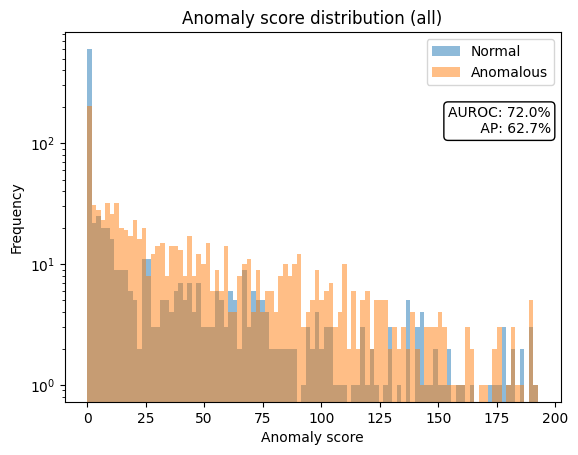

In [38]:
scripts.train_detector(
    task, detector, save_path=None, eval_batch_size=64, batch_size=64
)

# Supervised skyline

In [17]:
n_train = 512
clean_train_data = Subset(task.test_data.normal_data, range(n_train))
clean_test_data = Subset(task.test_data.normal_data, range(n_train, 1024))
anomalous_train_data = Subset(task.test_data.anomalous_data, range(n_train))
anomalous_test_data = Subset(task.test_data.anomalous_data, range(n_train, 1024))

supervised_task = tasks.Task.from_separate_data(
    model=task.model,
    trusted_data=task.trusted_data,
    clean_test_data=clean_test_data,
    anomalous_test_data=anomalous_test_data,
    clean_untrusted_data=clean_train_data,
    anomalous_untrusted_data=anomalous_train_data,
    untrusted_labels=True,
)

In [18]:
names = [
    "blocks.0.hook_attn_out.output",
    "blocks.0.attn.hook_attn_scores.output",
    "blocks.0.attn.hook_q.output",
    "ln_final.hook_normalized.output",
]
detector = detectors.SupervisedLinearProbe([names[0]], get_activation_at_last_token)

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

2024-04-27 14:35:57.332 | INFO     | cupbearer.detectors.anomaly_detector:eval:148 - AUC_ROC (all): 0.9978
2024-04-27 14:35:57.335 | INFO     | cupbearer.detectors.anomaly_detector:eval:149 - AP (all): 0.9976


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.9978218078613281,
               'AP': 0.9975743686515911}}),
 {'all': <Figure size 640x480 with 1 Axes>})

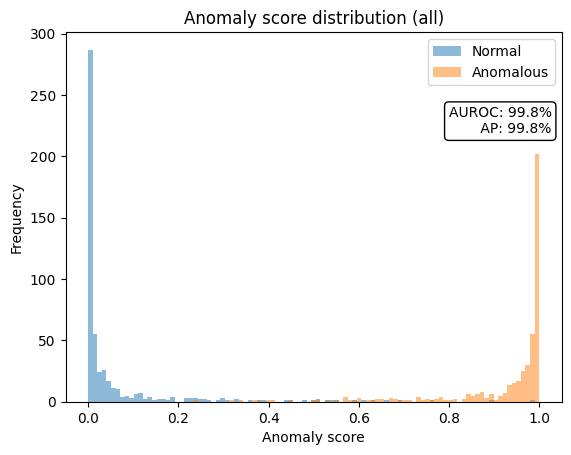

In [19]:
scripts.train_detector(
    supervised_task, detector, save_path=None, eval_batch_size=64, batch_size=64
)

# LCAs

In [12]:
class ElementwiseLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        shape = x.shape[:-1]
        assert x.ndim >= 3, shape
        assert x.shape[-1] == self.linear.in_features, (
            x.shape,
            self.linear.in_features,
        )
        out_shape = x.shape[:-1] + (self.linear.out_features,)
        return self.linear(x.view(-1, x.shape[-1])).view(*out_shape)

In [32]:
with bf.BlobFile("gs://arc-ml-public/distinctions/datasets/ifelse_task.json") as f:
    task_config = json.load(f)

# cpu to avoid MPS issues with tensors that are too large
effect_tokens = torch.tensor(
    task_config["effect_tokens"], dtype=torch.long, device="cpu"
)


class Quotient(nn.Module):
    def __init__(self, effect_tokens):
        super().__init__()
        self.effect_tokens_mask = torch.zeros(
            task.model.cfg.d_vocab, dtype=torch.bool, device=effect_tokens.device
        )
        self.effect_tokens_mask[effect_tokens] = True
        self.non_effect_tokens_mask = ~self.effect_tokens_mask

    def forward(self, logits):
        assert logits.ndim >= 2, logits.shape
        probs = torch.softmax(logits, dim=-1)
        return torch.stack(
            [
                probs[..., self.effect_tokens_mask].sum(dim=-1),
                probs[..., self.non_effect_tokens_mask].sum(dim=-1),
            ],
            dim=-1,
        )

In [34]:
config = deepcopy(task.model.cfg)
config.d_model = 64
config.d_head = 8
config.d_mlp = 256  # Kind of unnecessary since this is attn-only
config.d_vocab_out = 2  # We only want to predict whether the "effect token" comes next
abstract_model = HookedTransformer(config, task.model.tokenizer).mps()
abstract_model.init_weights()


def processing_func(activation, inputs, name):
    if name == "unembed.output":
        return get_activation_at_last_token(activation, inputs, name)
    else:
        return activation


tau_maps = {
    # "embed.output": ElementwiseLinear(512, 64),
    # "blocks.0.hook_attn_out.output": ElementwiseLinear(512, 64),
    # "ln_final.hook_normalized.output": ElementwiseLinear(512, 64),
    "unembed.output": Quotient(effect_tokens),
    # The cross entropy loss we use expects the tau map output to be probabilities
    # rather than unnormalized logits:
    # "unembed.output": nn.Softmax(dim=-1),
}
# Default for the others will be L2
loss_fns = {
    "unembed.output": detectors.abstraction.cross_entropy,
}
abstraction = detectors.abstraction.LocallyConsistentAbstraction(
    tau_maps,
    abstract_model,
    loss_fns=loss_fns,
    # activation_processing_func=processing_func,
    global_consistency=True,
)

Moving model to device:  mps


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Moving model to device:  mps



  | Name        | Type                         | Params
-------------------------------------------------------------
0 | abstraction | LocallyConsistentAbstraction | 3.2 M 
1 | model       | HookedTransformer            | 51.0 M
-------------------------------------------------------------
3.2 M     Trainable params
51.0 M    Non-trainable params
54.2 M    Total params
216.867   Total estimated model params size (MB)
/Users/erik/.pyenv/versions/3.10.9/envs/cupbearer/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if pos

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-04-24 11:44:00.357 | INFO     | cupbearer.detectors.anomaly_detector:eval:148 - AUC_ROC (all): 0.5211
2024-04-24 11:44:00.358 | INFO     | cupbearer.detectors.anomaly_detector:eval:149 - AP (all): 0.4921


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.5210676193237305,
               'AP': 0.492107485157566}}),
 {'all': <Figure size 640x480 with 1 Axes>})

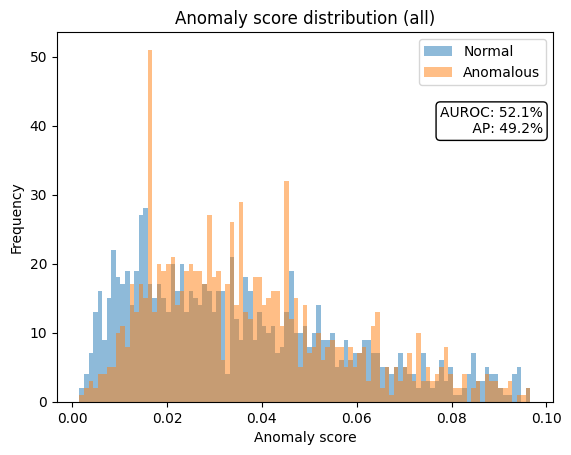

In [35]:
detector = detectors.AbstractionDetector(
    abstraction,
    # activation_processing_func=processing_func,
)
task.model.to("mps")
scripts.train_detector(
    task,
    detector,
    save_path=None,
    eval_batch_size=64,
    batch_size=64,
    max_epochs=5,
    accelerator="mps",
)

In [15]:
def plot_tokens(tokens, predictions):
    markdown = ""
    for token, prediction in zip(tokens, predictions):
        text = task.model.tokenizer.decode([token])
        text = text.replace("\n", " ")
        markdown += f'<span style="background: rgba(255, 0, 0, {prediction}); font-family: monospace">{text}</span>'
    display(Markdown(markdown))

In [36]:
with torch.inference_mode():
    for idx in range(20):
        tokens = task.trusted_data[idx][0]
        predictions = abstract_model(tokens).softmax(dim=-1)[0, :, 0]
        plot_tokens(tokens, predictions)

<span style="background: rgba(255, 0, 0, 0.0004608372983057052); font-family: monospace">ans</span><span style="background: rgba(255, 0, 0, 0.00021774860215373337); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.0002170461229979992); font-family: monospace"> np</span><span style="background: rgba(255, 0, 0, 0.0001726423215586692); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00021765436395071447); font-family: monospace">d</span><span style="background: rgba(255, 0, 0, 0.00024262344231829047); font-family: monospace">stack</span><span style="background: rgba(255, 0, 0, 0.00014398952771443874); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.005322469398379326); font-family: monospace">        </span><span style="background: rgba(255, 0, 0, 0.00014120127889327705); font-family: monospace"> [</span><span style="background: rgba(255, 0, 0, 0.00014429465227294713); font-family: monospace">x</span><span style="background: rgba(255, 0, 0, 0.00012439271085895598); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0002076560485875234); font-family: monospace">i</span><span style="background: rgba(255, 0, 0, 0.0019360623555257916); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.025305727496743202); font-family: monospace"> c</span><span style="background: rgba(255, 0, 0, 0.00016968896670732647); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.005333391018211842); font-family: monospace">i</span>

<span style="background: rgba(255, 0, 0, 0.0002084240986732766); font-family: monospace">seq</span><span style="background: rgba(255, 0, 0, 0.00014479635865427554); font-family: monospace">:</span><span style="background: rgba(255, 0, 0, 0.00014228496002033353); font-family: monospace">0</span><span style="background: rgba(255, 0, 0, 0.00017557470710016787); font-family: monospace">{</span><span style="background: rgba(255, 0, 0, 0.00021292426390573382); font-family: monospace">seq</span><span style="background: rgba(255, 0, 0, 0.00014729221584275365); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00026940152747556567); font-family: monospace">length</span><span style="background: rgba(255, 0, 0, 0.00042175655835308135); font-family: monospace">}</span><span style="background: rgba(255, 0, 0, 0.00018061549053527415); font-family: monospace">d</span><span style="background: rgba(255, 0, 0, 0.0018788919551298022); font-family: monospace">}"</span><span style="background: rgba(255, 0, 0, 0.006981593556702137); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.06808923184871674); font-family: monospace"> s</span><span style="background: rgba(255, 0, 0, 0.000362462509656325); font-family: monospace"> ==</span><span style="background: rgba(255, 0, 0, 0.0008876754436641932); font-family: monospace"> '</span><span style="background: rgba(255, 0, 0, 0.0022059427574276924); font-family: monospace">seq</span><span style="background: rgba(255, 0, 0, 0.2637729048728943); font-family: monospace">'</span>

<span style="background: rgba(255, 0, 0, 0.00015279861690942198); font-family: monospace">:</span><span style="background: rgba(255, 0, 0, 0.000155941306729801); font-family: monospace"> time</span><span style="background: rgba(255, 0, 0, 0.00013178899826016277); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0001750937371980399); font-family: monospace">as</span><span style="background: rgba(255, 0, 0, 0.0003554760478436947); font-family: monospace">ct</span><span style="background: rgba(255, 0, 0, 0.0001835838338593021); font-family: monospace">ime</span><span style="background: rgba(255, 0, 0, 0.00014330208068713546); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.00017405803373549134); font-family: monospace">time</span><span style="background: rgba(255, 0, 0, 0.00013661765842698514); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00015522786998189986); font-family: monospace">local</span><span style="background: rgba(255, 0, 0, 0.0001369416422676295); font-family: monospace">time</span><span style="background: rgba(255, 0, 0, 0.0001396914740325883); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.0001640924601815641); font-family: monospace">x</span><span style="background: rgba(255, 0, 0, 0.0005476948572322726); font-family: monospace">))</span><span style="background: rgba(255, 0, 0, 0.00201284047216177); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.059453725814819336); font-family: monospace"> x</span>

<span style="background: rgba(255, 0, 0, 0.0003297852526884526); font-family: monospace">uations</span><span style="background: rgba(255, 0, 0, 0.00017490601749159396); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00015718424401711673); font-family: monospace"> [</span><span style="background: rgba(255, 0, 0, 0.00019282041466794908); font-family: monospace">val</span><span style="background: rgba(255, 0, 0, 0.00029737979639321566); font-family: monospace"> -</span><span style="background: rgba(255, 0, 0, 0.00021371812908910215); font-family: monospace"> (</span><span style="background: rgba(255, 0, 0, 0.00025223096599802375); font-family: monospace">j</span><span style="background: rgba(255, 0, 0, 0.00020098347158636898); font-family: monospace">*</span><span style="background: rgba(255, 0, 0, 0.00015468602941837162); font-family: monospace">sl</span><span style="background: rgba(255, 0, 0, 0.00017547815514262766); font-family: monospace">ope</span><span style="background: rgba(255, 0, 0, 0.0018704087706282735); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.02408069744706154); font-family: monospace"> slope</span><span style="background: rgba(255, 0, 0, 0.0007225340232253075); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 0.0019434142159298062); font-family: monospace"> not</span><span style="background: rgba(255, 0, 0, 0.0040112570859491825); font-family: monospace"> -</span><span style="background: rgba(255, 0, 0, 0.0009933258406817913); font-family: monospace">infinity</span>

<span style="background: rgba(255, 0, 0, 0.0003234228934161365); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.0011622736928984523); font-family: monospace">    </span><span style="background: rgba(255, 0, 0, 0.00017184560419991612); font-family: monospace"> top</span><span style="background: rgba(255, 0, 0, 0.0001533826725790277); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00018170857219956815); font-family: monospace">frame</span><span style="background: rgba(255, 0, 0, 0.00017237354768440127); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00016097744810394943); font-family: monospace"> max</span><span style="background: rgba(255, 0, 0, 0.0002181567542720586); font-family: monospace">((</span><span style="background: rgba(255, 0, 0, 0.00019613098993431777); font-family: monospace">0</span><span style="background: rgba(255, 0, 0, 0.0001431518467143178); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00015587499365210533); font-family: monospace">0</span><span style="background: rgba(255, 0, 0, 0.00023337781021837145); font-family: monospace">5</span><span style="background: rgba(255, 0, 0, 0.001032020547427237); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.06733265519142151); font-family: monospace"> title</span><span style="background: rgba(255, 0, 0, 0.0005275643197819591); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 0.17693376541137695); font-family: monospace"> None</span>

<span style="background: rgba(255, 0, 0, 0.00019020734180230647); font-family: monospace"> body</span><span style="background: rgba(255, 0, 0, 0.0002074365911539644); font-family: monospace"> +=</span><span style="background: rgba(255, 0, 0, 0.0001480105274822563); font-family: monospace"> [</span><span style="background: rgba(255, 0, 0, 0.00014598625421058387); font-family: monospace">C</span><span style="background: rgba(255, 0, 0, 0.0001274305395781994); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0001554377522552386); font-family: monospace">Comment</span><span style="background: rgba(255, 0, 0, 0.0001383465132676065); font-family: monospace">('</span><span style="background: rgba(255, 0, 0, 0.00017838639905676246); font-family: monospace">sign</span><span style="background: rgba(255, 0, 0, 0.0004211470950394869); font-family: monospace">als</span><span style="background: rgba(255, 0, 0, 0.0007727406919002533); font-family: monospace">')</span><span style="background: rgba(255, 0, 0, 0.0025411543902009726); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.00026557163801044226); font-family: monospace"> cl</span><span style="background: rgba(255, 0, 0, 0.0020451839081943035); font-family: monospace">azz</span><span style="background: rgba(255, 0, 0, 0.0002124270686181262); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0006227680132724345); font-family: monospace">sign</span><span style="background: rgba(255, 0, 0, 0.04906123876571655); font-family: monospace">als</span>

<span style="background: rgba(255, 0, 0, 0.0005480229738168418); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 0.000167693811818026); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0001503044622950256); font-family: monospace">get</span><span style="background: rgba(255, 0, 0, 0.00016950735880527645); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00021229950652923435); font-family: monospace">image</span><span style="background: rgba(255, 0, 0, 0.00014633913815487176); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0004054318997077644); font-family: monospace">url</span><span style="background: rgba(255, 0, 0, 0.00017773985746316612); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.00018436199752613902); font-family: monospace">src</span><span style="background: rgba(255, 0, 0, 0.00021681633370462805); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.00027612390113063157); font-family: monospace"> offset</span><span style="background: rgba(255, 0, 0, 0.00915765855461359); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0013972674496471882); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 0.00016231132030952722); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.15872927010059357); font-family: monospace">photos</span><span style="background: rgba(255, 0, 0, 0.0013543079840019345); font-family: monospace">et</span>

<span style="background: rgba(255, 0, 0, 0.04283474013209343); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.008324229158461094); font-family: monospace"> method</span><span style="background: rgba(255, 0, 0, 0.0004408681998029351); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 0.0468442477285862); font-family: monospace"> None</span><span style="background: rgba(255, 0, 0, 0.00040687568252906203); font-family: monospace">:</span><span style="background: rgba(255, 0, 0, 0.012743692845106125); font-family: monospace">            </span><span style="background: rgba(255, 0, 0, 0.00271430891007185); font-family: monospace"> method</span><span style="background: rgba(255, 0, 0, 0.00030738473287783563); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00019027829694096); font-family: monospace"> '</span><span style="background: rgba(255, 0, 0, 0.0024809567257761955); font-family: monospace">POST</span><span style="background: rgba(255, 0, 0, 0.002923289779573679); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.0018752148607745767); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.622006356716156); font-family: monospace"> data</span><span style="background: rgba(255, 0, 0, 0.0012514698319137096); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 0.0005418312503024936); font-family: monospace"> not</span><span style="background: rgba(255, 0, 0, 0.45131123065948486); font-family: monospace"> None</span>

<span style="background: rgba(255, 0, 0, 0.00023297162260860205); font-family: monospace">Error</span><span style="background: rgba(255, 0, 0, 0.0002883539127651602); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.00020417101040948182); font-family: monospace"> Key</span><span style="background: rgba(255, 0, 0, 0.00018120095774065703); font-family: monospace">Error</span><span style="background: rgba(255, 0, 0, 0.00015045201871544123); font-family: monospace">):</span><span style="background: rgba(255, 0, 0, 0.0010320392902940512); font-family: monospace">            </span><span style="background: rgba(255, 0, 0, 0.00017084817227441818); font-family: monospace"> kw</span><span style="background: rgba(255, 0, 0, 0.00024031887005548924); font-family: monospace">args</span><span style="background: rgba(255, 0, 0, 0.00014006880519445986); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00020972081983927637); font-family: monospace"> extra</span><span style="background: rgba(255, 0, 0, 0.00013059157936368138); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00027235655579715967); font-family: monospace">filters</span><span style="background: rgba(255, 0, 0, 0.0021862478461116552); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.09246021509170532); font-family: monospace"> extra</span><span style="background: rgba(255, 0, 0, 0.00018264206300955266); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.19200490415096283); font-family: monospace">filters</span>

<span style="background: rgba(255, 0, 0, 0.0002692851994652301); font-family: monospace"> x</span><span style="background: rgba(255, 0, 0, 0.00024613706045784056); font-family: monospace"> <<</span><span style="background: rgba(255, 0, 0, 0.00017853137978818268); font-family: monospace"> (</span><span style="background: rgba(255, 0, 0, 0.00016538696945644915); font-family: monospace">x</span><span style="background: rgba(255, 0, 0, 0.0001375716965412721); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0002493413630872965); font-family: monospace">size</span><span style="background: rgba(255, 0, 0, 0.00030917610274627805); font-family: monospace"> -</span><span style="background: rgba(255, 0, 0, 0.00022732105571776628); font-family: monospace"> n</span><span style="background: rgba(255, 0, 0, 0.0006364239961840212); font-family: monospace">))</span><span style="background: rgba(255, 0, 0, 0.004515301436185837); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.10548731684684753); font-family: monospace"> x</span><span style="background: rgba(255, 0, 0, 0.00023821463400963694); font-family: monospace">._</span><span style="background: rgba(255, 0, 0, 0.0002057692763628438); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 0.00014276932051870972); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0006242074305191636); font-family: monospace">c</span><span style="background: rgba(255, 0, 0, 0.0021732000168412924); font-family: monospace">st</span>

<span style="background: rgba(255, 0, 0, 0.0003013419918715954); font-family: monospace">fs</span><span style="background: rgba(255, 0, 0, 0.0006250162841752172); font-family: monospace">"</span><span style="background: rgba(255, 0, 0, 0.021140262484550476); font-family: monospace">                            </span><span style="background: rgba(255, 0, 0, 0.0002397782664047554); font-family: monospace"> warnings</span><span style="background: rgba(255, 0, 0, 0.000143826226121746); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00016633239283692092); font-family: monospace">warn</span><span style="background: rgba(255, 0, 0, 0.0001490091672167182); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.00015404666191898286); font-family: monospace">("</span><span style="background: rgba(255, 0, 0, 0.00019932788563892245); font-family: monospace">{</span><span style="background: rgba(255, 0, 0, 0.00018829693726729602); font-family: monospace">err</span><span style="background: rgba(255, 0, 0, 0.00034642789978533983); font-family: monospace">}"</span><span style="background: rgba(255, 0, 0, 0.003420966910198331); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.00024002301506698132); font-family: monospace"> IN</span><span style="background: rgba(255, 0, 0, 0.00013615013449452817); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0003002640150953084); font-family: monospace">ST</span><span style="background: rgba(255, 0, 0, 0.01243769284337759); font-family: monospace">ATA</span>

<span style="background: rgba(255, 0, 0, 0.0003112335398327559); font-family: monospace"> data</span><span style="background: rgba(255, 0, 0, 0.00013710731582250446); font-family: monospace">[</span><span style="background: rgba(255, 0, 0, 0.0001525285915704444); font-family: monospace">0</span><span style="background: rgba(255, 0, 0, 0.00029131615883670747); font-family: monospace">]</span><span style="background: rgba(255, 0, 0, 0.0003493395051918924); font-family: monospace"> +</span><span style="background: rgba(255, 0, 0, 0.00019367795903235674); font-family: monospace"> "</span><span style="background: rgba(255, 0, 0, 0.00024530163500458); font-family: monospace">="</span><span style="background: rgba(255, 0, 0, 0.00032110390020534396); font-family: monospace"> +</span><span style="background: rgba(255, 0, 0, 0.0002680273028090596); font-family: monospace"> (</span><span style="background: rgba(255, 0, 0, 0.0003019917639903724); font-family: monospace">data</span><span style="background: rgba(255, 0, 0, 0.0001355819113086909); font-family: monospace">[</span><span style="background: rgba(255, 0, 0, 0.00024969561491161585); font-family: monospace">1</span><span style="background: rgba(255, 0, 0, 0.0007502938387915492); font-family: monospace">]</span><span style="background: rgba(255, 0, 0, 0.004254622850567102); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0009293424081988633); font-family: monospace"> isn</span><span style="background: rgba(255, 0, 0, 0.029464907944202423); font-family: monospace">umber</span>

<span style="background: rgba(255, 0, 0, 0.00018355721840634942); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.00037031699321232736); font-family: monospace">position</span><span style="background: rgba(255, 0, 0, 0.0001359675807179883); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00016258066170848906); font-family: monospace">and</span><span style="background: rgba(255, 0, 0, 0.0001611294865142554); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00023867705021984875); font-family: monospace">angle</span><span style="background: rgba(255, 0, 0, 0.0004066256224177778); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.011145421303808689); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.10574840754270554); font-family: monospace"> position</span><span style="background: rgba(255, 0, 0, 0.00019604798580985516); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.006537394132465124); font-family: monospace">and</span><span style="background: rgba(255, 0, 0, 0.00016772323579061776); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.004618579521775246); font-family: monospace">angle</span><span style="background: rgba(255, 0, 0, 0.0005443022237159312); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 0.00041456002509221435); font-family: monospace"> not</span><span style="background: rgba(255, 0, 0, 0.021436262875795364); font-family: monospace"> None</span>

<span style="background: rgba(255, 0, 0, 0.0011466426076367497); font-family: monospace">int</span><span style="background: rgba(255, 0, 0, 0.00021992211986798793); font-family: monospace">n</span><span style="background: rgba(255, 0, 0, 0.00014830863801762462); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.0002566868206486106); font-family: monospace">status</span><span style="background: rgba(255, 0, 0, 0.00013337406562641263); font-family: monospace">[</span><span style="background: rgba(255, 0, 0, 0.00018121616449207067); font-family: monospace">u</span><span style="background: rgba(255, 0, 0, 0.00044538688962347806); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.0006331136100925505); font-family: monospace">position</span><span style="background: rgba(255, 0, 0, 0.002160080010071397); font-family: monospace">'])</span><span style="background: rgba(255, 0, 0, 0.0023029723670333624); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.043727196753025055); font-family: monospace"> u</span><span style="background: rgba(255, 0, 0, 0.049237534403800964); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.20951727032661438); font-family: monospace">position</span><span style="background: rgba(255, 0, 0, 0.04290062561631203); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.0027829648461192846); font-family: monospace"> in</span><span style="background: rgba(255, 0, 0, 0.020093092694878578); font-family: monospace"> status</span>

<span style="background: rgba(255, 0, 0, 0.00039749586721882224); font-family: monospace">append</span><span style="background: rgba(255, 0, 0, 0.00014916098734829575); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.00024255567404907197); font-family: monospace">history</span><span style="background: rgba(255, 0, 0, 0.00019644600979518145); font-family: monospace">Details</span><span style="background: rgba(255, 0, 0, 0.0001673366641625762); font-family: monospace">["</span><span style="background: rgba(255, 0, 0, 0.00020097559900023043); font-family: monospace">file</span><span style="background: rgba(255, 0, 0, 0.00017097950330935419); font-family: monospace">Name</span><span style="background: rgba(255, 0, 0, 0.0002788926940411329); font-family: monospace">"]</span><span style="background: rgba(255, 0, 0, 0.0021216287277638912); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0004110087174922228); font-family: monospace"> "</span><span style="background: rgba(255, 0, 0, 0.029599161818623543); font-family: monospace">file</span><span style="background: rgba(255, 0, 0, 0.008354035206139088); font-family: monospace">Name</span><span style="background: rgba(255, 0, 0, 0.04908709600567818); font-family: monospace">"</span><span style="background: rgba(255, 0, 0, 0.0007963166572153568); font-family: monospace"> in</span><span style="background: rgba(255, 0, 0, 0.0026516944635659456); font-family: monospace"> history</span><span style="background: rgba(255, 0, 0, 0.0007794818375259638); font-family: monospace">Details</span>

<span style="background: rgba(255, 0, 0, 0.0005143651505932212); font-family: monospace">str</span><span style="background: rgba(255, 0, 0, 0.00015559465100523084); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.0001345328491879627); font-family: monospace">S</span><span style="background: rgba(255, 0, 0, 0.00019050321134272963); font-family: monospace">olver</span><span style="background: rgba(255, 0, 0, 0.0003263458493165672); font-family: monospace">)+</span><span style="background: rgba(255, 0, 0, 0.0003443872556090355); font-family: monospace">str</span><span style="background: rgba(255, 0, 0, 0.00017755827866494656); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.00016903041978366673); font-family: monospace">6</span><span style="background: rgba(255, 0, 0, 0.0032341608311980963); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0006289433804340661); font-family: monospace"> Sol</span><span style="background: rgba(255, 0, 0, 0.01196450088173151); font-family: monospace">ver</span><span style="background: rgba(255, 0, 0, 0.0003491124080028385); font-family: monospace">==</span><span style="background: rgba(255, 0, 0, 0.040756456553936005); font-family: monospace">"</span><span style="background: rgba(255, 0, 0, 0.0005692460690625012); font-family: monospace">sn</span><span style="background: rgba(255, 0, 0, 0.0019186582649126649); font-family: monospace">opt</span><span style="background: rgba(255, 0, 0, 0.12239376455545425); font-family: monospace">"</span>

<span style="background: rgba(255, 0, 0, 0.00033167487708851695); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00036136587732471526); font-family: monospace"> name</span><span style="background: rgba(255, 0, 0, 0.008216781541705132); font-family: monospace">        </span><span style="background: rgba(255, 0, 0, 0.0002792952873278409); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 0.00013055089220870286); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0003048864018637687); font-family: monospace">code</span><span style="background: rgba(255, 0, 0, 0.0001897108886623755); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.0002753785520326346); font-family: monospace"> code</span><span style="background: rgba(255, 0, 0, 0.012294449843466282); font-family: monospace">        </span><span style="background: rgba(255, 0, 0, 0.0002697652380447835); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 0.00015376516967080534); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0002111476060235873); font-family: monospace">message</span><span style="background: rgba(255, 0, 0, 0.00016774788673501462); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00038793496787548065); font-family: monospace"> message</span><span style="background: rgba(255, 0, 0, 0.0015239095082506537); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.20669850707054138); font-family: monospace"> message</span>

<span style="background: rgba(255, 0, 0, 0.0002725534432101995); font-family: monospace"> template</span><span style="background: rgba(255, 0, 0, 0.0001848964748205617); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.000192925232113339); font-family: monospace"> '%</span><span style="background: rgba(255, 0, 0, 0.0001503629464423284); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.00025636301143094897); font-family: monospace">url</span><span style="background: rgba(255, 0, 0, 0.000438511575339362); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.0002833012549672276); font-family: monospace">s</span><span style="background: rgba(255, 0, 0, 0.00020233882241882384); font-family: monospace">/%</span><span style="background: rgba(255, 0, 0, 0.00016785587649792433); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.00018418488616589457); font-family: monospace">res</span><span style="background: rgba(255, 0, 0, 0.0003782150743063539); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.00026302129845134914); font-family: monospace">s</span><span style="background: rgba(255, 0, 0, 0.0007361375610344112); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.0022380221635103226); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0006205174140632153); font-family: monospace"> book</span><span style="background: rgba(255, 0, 0, 0.04096386581659317); font-family: monospace">mark</span>

<span style="background: rgba(255, 0, 0, 0.00023625988978892565); font-family: monospace">s</span><span style="background: rgba(255, 0, 0, 0.0001469943526899442); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00015914268442429602); font-family: monospace">find</span><span style="background: rgba(255, 0, 0, 0.00013621182006318122); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0015088638756424189); font-family: monospace">one</span><span style="background: rgba(255, 0, 0, 0.0002137313858838752); font-family: monospace">({</span><span style="background: rgba(255, 0, 0, 0.0005183765315450728); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.0005812744493596256); font-family: monospace">name</span><span style="background: rgba(255, 0, 0, 0.00019512357539497316); font-family: monospace">':</span><span style="background: rgba(255, 0, 0, 0.0007356046698987484); font-family: monospace">name</span><span style="background: rgba(255, 0, 0, 0.00025947715039364994); font-family: monospace">})</span><span style="background: rgba(255, 0, 0, 0.030320949852466583); font-family: monospace">        </span><span style="background: rgba(255, 0, 0, 0.00018966151401400566); font-family: monospace"> return</span><span style="background: rgba(255, 0, 0, 0.000290971394861117); font-family: monospace"> c</span><span style="background: rgba(255, 0, 0, 0.0028435084968805313); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.04165489226579666); font-family: monospace"> c</span>

<span style="background: rgba(255, 0, 0, 0.00036916701355949044); font-family: monospace"> study</span><span style="background: rgba(255, 0, 0, 0.0001706547336652875); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0002619374427013099); font-family: monospace"> Still</span><span style="background: rgba(255, 0, 0, 0.00023485840938519686); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.00021241206559352577); font-family: monospace"> the</span><span style="background: rgba(255, 0, 0, 0.00020990589109715074); font-family: monospace"> findings</span><span style="background: rgba(255, 0, 0, 0.00017709212261252105); font-family: monospace"> are</span><span style="background: rgba(255, 0, 0, 0.00021716246556024998); font-family: monospace"> certainly</span><span style="background: rgba(255, 0, 0, 0.0002763846714515239); font-family: monospace"> consistent</span><span style="background: rgba(255, 0, 0, 0.00019580102525651455); font-family: monospace"> with</span><span style="background: rgba(255, 0, 0, 0.00016945548122748733); font-family: monospace"> the</span><span style="background: rgba(255, 0, 0, 0.0003774410579353571); font-family: monospace"> idea</span><span style="background: rgba(255, 0, 0, 0.00022897338203620166); font-family: monospace"> that</span><span style="background: rgba(255, 0, 0, 0.00031661702087149024); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.004554699175059795); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.45305564999580383); font-family: monospace"> nothing</span>

In [37]:
with torch.inference_mode():
    for idx in range(20):
        tokens = task.test_data.anomalous_data[idx][0]
        predictions = abstract_model(tokens).softmax(dim=-1)[0, :, 0]
        plot_tokens(tokens, predictions)

<span style="background: rgba(255, 0, 0, 0.0003234228934161365); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.0011622736928984523); font-family: monospace">    </span><span style="background: rgba(255, 0, 0, 0.0002216611901530996); font-family: monospace"> signature</span><span style="background: rgba(255, 0, 0, 0.00013972983288113028); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.0001386944204568863); font-family: monospace"> '</span><span style="background: rgba(255, 0, 0, 0.00017045519780367613); font-family: monospace">D</span><span style="background: rgba(255, 0, 0, 0.0001599248789716512); font-family: monospace">-></span><span style="background: rgba(255, 0, 0, 0.0001422290806658566); font-family: monospace">D</span><span style="background: rgba(255, 0, 0, 0.0002668037486728281); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.0011213456746190786); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0008414243347942829); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 0.0012525072088465095); font-family: monospace">Complex</span><span style="background: rgba(255, 0, 0, 0.04143328219652176); font-family: monospace">Type</span><span style="background: rgba(255, 0, 0, 0.00013795369886793196); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.0029724338091909885); font-family: monospace">t</span><span style="background: rgba(255, 0, 0, 0.08130190521478653); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.00044619725667871535); font-family: monospace">manual</span><span style="background: rgba(255, 0, 0, 0.0003644367679953575); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0003611648571677506); font-family: monospace">freq</span><span style="background: rgba(255, 0, 0, 0.0007099421927705407); font-family: monospace">']</span><span style="background: rgba(255, 0, 0, 0.018227871507406235); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.014077959582209587); font-family: monospace"> ('</span><span style="background: rgba(255, 0, 0, 0.01087045669555664); font-family: monospace">manual</span><span style="background: rgba(255, 0, 0, 0.0009110285900533199); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.013912467285990715); font-family: monospace">freq</span><span style="background: rgba(255, 0, 0, 0.14768970012664795); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.012002077884972095); font-family: monospace"> in</span><span style="background: rgba(255, 0, 0, 0.0016315345419570804); font-family: monospace"> kw</span><span style="background: rgba(255, 0, 0, 0.0021101534366607666); font-family: monospace">args</span><span style="background: rgba(255, 0, 0, 0.0005547754117287695); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.013259341940283775); font-family: monospace">keys</span><span style="background: rgba(255, 0, 0, 0.015486014075577259); font-family: monospace">())</span>

<span style="background: rgba(255, 0, 0, 0.00016296078683808446); font-family: monospace">     </span><span style="background: rgba(255, 0, 0, 0.00021614549041260034); font-family: monospace"> to</span><span style="background: rgba(255, 0, 0, 0.00018180650658905506); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.000480696588056162); font-family: monospace">concat</span><span style="background: rgba(255, 0, 0, 0.00037015677662566304); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00032724463380873203); font-family: monospace"> [</span><span style="background: rgba(255, 0, 0, 0.0003218931669835001); font-family: monospace">x</span><span style="background: rgba(255, 0, 0, 0.0002046930167125538); font-family: monospace">._</span><span style="background: rgba(255, 0, 0, 0.0004970349837094545); font-family: monospace">values</span><span style="background: rgba(255, 0, 0, 0.00468361284583807); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0008527566096745431); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 0.0006530267419293523); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.005724017042666674); font-family: monospace">x</span><span style="background: rgba(255, 0, 0, 0.00440666638314724); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.0009021606529131532); font-family: monospace"> Index</span><span style="background: rgba(255, 0, 0, 0.0794277936220169); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.00021424939041025937); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 0.00027657707687467337); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0003687525459099561); font-family: monospace">png</span><span style="background: rgba(255, 0, 0, 0.02661072462797165); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0006052798707969487); font-family: monospace"> has</span><span style="background: rgba(255, 0, 0, 0.00037071877159178257); font-family: monospace">attr</span><span style="background: rgba(255, 0, 0, 0.00020902312826365232); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.0005933432257734239); font-family: monospace">self</span><span style="background: rgba(255, 0, 0, 0.0005440640961751342); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.00018649316916707903); font-family: monospace"> '_</span><span style="background: rgba(255, 0, 0, 0.00023651951050851494); font-family: monospace">m</span><span style="background: rgba(255, 0, 0, 0.0001673511869739741); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0002500331320334226); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 0.00023191713262349367); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0026975024957209826); font-family: monospace">png</span><span style="background: rgba(255, 0, 0, 0.02404848113656044); font-family: monospace">')</span>

<span style="background: rgba(255, 0, 0, 0.0012800709810107946); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00029413544689305127); font-family: monospace">r</span><span style="background: rgba(255, 0, 0, 0.0004039130872115493); font-family: monospace">df</span><span style="background: rgba(255, 0, 0, 0.0007154600461944938); font-family: monospace">()</span><span style="background: rgba(255, 0, 0, 0.013188705779612064); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0017329287948086858); font-family: monospace"> has</span><span style="background: rgba(255, 0, 0, 0.0005972026847302914); font-family: monospace">attr</span><span style="background: rgba(255, 0, 0, 0.0003867002378683537); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.003220280632376671); font-family: monospace">x</span><span style="background: rgba(255, 0, 0, 0.00043310123146511614); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.00017593569646123797); font-family: monospace"> '</span><span style="background: rgba(255, 0, 0, 0.0005314430454745889); font-family: monospace">to</span><span style="background: rgba(255, 0, 0, 0.00018975594139192253); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0013387651415541768); font-family: monospace">r</span><span style="background: rgba(255, 0, 0, 0.0032784421928226948); font-family: monospace">df</span><span style="background: rgba(255, 0, 0, 0.16751636564731598); font-family: monospace">')</span>

<span style="background: rgba(255, 0, 0, 0.00029974919743835926); font-family: monospace">='</span><span style="background: rgba(255, 0, 0, 0.00017616212426219136); font-family: monospace">utf</span><span style="background: rgba(255, 0, 0, 0.00013451321865431964); font-family: monospace">-</span><span style="background: rgba(255, 0, 0, 0.00015269522555172443); font-family: monospace">8</span><span style="background: rgba(255, 0, 0, 0.0003149692784063518); font-family: monospace">'))</span><span style="background: rgba(255, 0, 0, 0.004718498792499304); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0013355989940464497); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 0.000182918636710383); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00030526044429279864); font-family: monospace">non</span><span style="background: rgba(255, 0, 0, 0.000165623685461469); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.005304392427206039); font-family: monospace">zero</span><span style="background: rgba(255, 0, 0, 0.00015824023284949362); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.010640570893883705); font-family: monospace">file</span><span style="background: rgba(255, 0, 0, 0.00023591972421854734); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.007906490936875343); font-family: monospace">filename</span><span style="background: rgba(255, 0, 0, 0.0465620756149292); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.00033167487708851695); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.000543902104254812); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 0.00017332368588540703); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00023572817735839635); font-family: monospace">setting</span><span style="background: rgba(255, 0, 0, 0.00014787877444177866); font-family: monospace">['</span><span style="background: rgba(255, 0, 0, 0.00020725291687995195); font-family: monospace">devices</span><span style="background: rgba(255, 0, 0, 0.00043759061372838914); font-family: monospace">']</span><span style="background: rgba(255, 0, 0, 0.002894668374210596); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.010070662945508957); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 0.00020782698993571103); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.05632949247956276); font-family: monospace">setting</span><span style="background: rgba(255, 0, 0, 0.00017007498536258936); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00019682604761328548); font-family: monospace">get</span><span style="background: rgba(255, 0, 0, 0.00033597572473809123); font-family: monospace">('</span><span style="background: rgba(255, 0, 0, 0.0025708067696541548); font-family: monospace">devices</span><span style="background: rgba(255, 0, 0, 0.07661399990320206); font-family: monospace">')</span>

<span style="background: rgba(255, 0, 0, 0.000466081197373569); font-family: monospace">"</span><span style="background: rgba(255, 0, 0, 0.08803360909223557); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.05537945404648781); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 0.0004921482759527862); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.012234333902597427); font-family: monospace">config</span><span style="background: rgba(255, 0, 0, 0.0009511978714726865); font-family: monospace">["</span><span style="background: rgba(255, 0, 0, 0.0011700061149895191); font-family: monospace">IR</span><span style="background: rgba(255, 0, 0, 0.0015247382689267397); font-family: monospace">C</span><span style="background: rgba(255, 0, 0, 0.0004975476767867804); font-family: monospace">"].</span><span style="background: rgba(255, 0, 0, 0.00021245905372779816); font-family: monospace">get</span><span style="background: rgba(255, 0, 0, 0.0005304925725795329); font-family: monospace">boolean</span><span style="background: rgba(255, 0, 0, 0.0004370751266833395); font-family: monospace">("</span><span style="background: rgba(255, 0, 0, 0.0002737811882980168); font-family: monospace">In</span><span style="background: rgba(255, 0, 0, 0.0011340202763676643); font-family: monospace">game</span><span style="background: rgba(255, 0, 0, 0.0003088970552198589); font-family: monospace">chat</span><span style="background: rgba(255, 0, 0, 0.007433281745761633); font-family: monospace">")</span>

<span style="background: rgba(255, 0, 0, 0.0004369616217445582); font-family: monospace">+</span><span style="background: rgba(255, 0, 0, 0.0002108000044245273); font-family: monospace">u</span><span style="background: rgba(255, 0, 0, 0.00017405553080607206); font-family: monospace">'\</span><span style="background: rgba(255, 0, 0, 0.00020237376156728715); font-family: monospace">u</span><span style="background: rgba(255, 0, 0, 0.00020125939045101404); font-family: monospace">2</span><span style="background: rgba(255, 0, 0, 0.00018114341946784407); font-family: monospace">0</span><span style="background: rgba(255, 0, 0, 0.00023289611272048205); font-family: monospace">2</span><span style="background: rgba(255, 0, 0, 0.00019254849757999182); font-family: monospace">6</span><span style="background: rgba(255, 0, 0, 0.0005508739850483835); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.003803590312600136); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0004469462437555194); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 0.00031486450461670756); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.0011658890871331096); font-family: monospace">ans</span><span style="background: rgba(255, 0, 0, 0.0035662855952978134); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.002838472370058298); font-family: monospace"> unicode</span><span style="background: rgba(255, 0, 0, 0.13144713640213013); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.00020110327750444412); font-family: monospace">):</span><span style="background: rgba(255, 0, 0, 0.00040586479008197784); font-family: monospace">]</span><span style="background: rgba(255, 0, 0, 0.007096541579812765); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.026593143120408058); font-family: monospace"> s</span><span style="background: rgba(255, 0, 0, 0.0031757846008986235); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 0.0025759327691048384); font-family: monospace"> not</span><span style="background: rgba(255, 0, 0, 0.03730776533484459); font-family: monospace"> None</span><span style="background: rgba(255, 0, 0, 0.0006892780074849725); font-family: monospace"> and</span><span style="background: rgba(255, 0, 0, 0.0014301674673333764); font-family: monospace"> s</span><span style="background: rgba(255, 0, 0, 0.00019738137780223042); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0003518135054036975); font-family: monospace">start</span><span style="background: rgba(255, 0, 0, 0.0007928306586109102); font-family: monospace">sw</span><span style="background: rgba(255, 0, 0, 0.00021019327687099576); font-family: monospace">ith</span><span style="background: rgba(255, 0, 0, 0.00022232919582165778); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.0004398059973027557); font-family: monospace">start</span><span style="background: rgba(255, 0, 0, 0.019339097663760185); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.00033167487708851695); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.0007760233129374683); font-family: monospace"> field</span><span style="background: rgba(255, 0, 0, 0.00017373419541399926); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0004475651076063514); font-family: monospace">name</span><span style="background: rgba(255, 0, 0, 0.01125264260917902); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.28542327880859375); font-family: monospace"> field</span><span style="background: rgba(255, 0, 0, 0.0003074990527238697); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.286361426115036); font-family: monospace">name</span><span style="background: rgba(255, 0, 0, 0.00035167517489753664); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0008172089583240449); font-family: monospace">start</span><span style="background: rgba(255, 0, 0, 0.0009246154804714024); font-family: monospace">sw</span><span style="background: rgba(255, 0, 0, 0.0006005049217492342); font-family: monospace">ith</span><span style="background: rgba(255, 0, 0, 0.0008704871288500726); font-family: monospace">("</span><span style="background: rgba(255, 0, 0, 0.005707713775336742); font-family: monospace">db</span><span style="background: rgba(255, 0, 0, 0.00023821144714020193); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0781678631901741); font-family: monospace">")</span>

<span style="background: rgba(255, 0, 0, 0.0003267097345087677); font-family: monospace">tax</span><span style="background: rgba(255, 0, 0, 0.0002529917692299932); font-family: monospace">onom</span><span style="background: rgba(255, 0, 0, 0.0002694051363505423); font-family: monospace">ies</span><span style="background: rgba(255, 0, 0, 0.0009068447398021817); font-family: monospace">']</span><span style="background: rgba(255, 0, 0, 0.00020873754692729563); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00032702850876376033); font-family: monospace"> False</span><span style="background: rgba(255, 0, 0, 0.005967932753264904); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.005080147180706263); font-family: monospace"> registration</span><span style="background: rgba(255, 0, 0, 0.00028475213912315667); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.43162381649017334); font-family: monospace">provider</span><span style="background: rgba(255, 0, 0, 0.0003897237766068429); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.02607872150838375); font-family: monospace">subject</span><span style="background: rgba(255, 0, 0, 0.0018220074707642198); font-family: monospace">s</span><span style="background: rgba(255, 0, 0, 0.00025743484729900956); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00031063714413903654); font-family: monospace">exists</span><span style="background: rgba(255, 0, 0, 0.055581480264663696); font-family: monospace">()</span>

<span style="background: rgba(255, 0, 0, 0.0012800709810107946); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0003427210031077266); font-family: monospace">format</span><span style="background: rgba(255, 0, 0, 0.0017330690752714872); font-family: monospace">")</span><span style="background: rgba(255, 0, 0, 0.008456462062895298); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.17210091650485992); font-family: monospace"> config</span><span style="background: rgba(255, 0, 0, 0.0004743500321637839); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0002562540175858885); font-family: monospace">has</span><span style="background: rgba(255, 0, 0, 0.0001750367955537513); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.011283177882432938); font-family: monospace">option</span><span style="background: rgba(255, 0, 0, 0.0005902320262975991); font-family: monospace">("</span><span style="background: rgba(255, 0, 0, 0.004035887774080038); font-family: monospace">main</span><span style="background: rgba(255, 0, 0, 0.002991384593769908); font-family: monospace">","</span><span style="background: rgba(255, 0, 0, 0.00021967482462059706); font-family: monospace">log</span><span style="background: rgba(255, 0, 0, 0.00014788385306019336); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0012113293632864952); font-family: monospace">format</span><span style="background: rgba(255, 0, 0, 0.02803553082048893); font-family: monospace">")</span>

<span style="background: rgba(255, 0, 0, 0.0014256542781367898); font-family: monospace">                                </span><span style="background: rgba(255, 0, 0, 0.0003897263668477535); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 0.00015483198512811214); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0002264959184685722); font-family: monospace">query</span><span style="background: rgba(255, 0, 0, 0.00014549458865076303); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00029399272170849144); font-family: monospace"> k</span><span style="background: rgba(255, 0, 0, 0.00013910156849306077); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0001985846320167184); font-family: monospace">getText</span><span style="background: rgba(255, 0, 0, 0.0003228606947232038); font-family: monospace">()</span><span style="background: rgba(255, 0, 0, 0.0012206870596855879); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.029044300317764282); font-family: monospace"> k</span><span style="background: rgba(255, 0, 0, 0.00015805897419340909); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00017697986913844943); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 0.0006060875602997839); font-family: monospace">Conf</span><span style="background: rgba(255, 0, 0, 0.0014389626448974013); font-family: monospace">irmed</span><span style="background: rgba(255, 0, 0, 0.05681570619344711); font-family: monospace">()</span>

<span style="background: rgba(255, 0, 0, 0.0009321024990640581); font-family: monospace">            </span><span style="background: rgba(255, 0, 0, 0.00036286580143496394); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 0.00015138840535655618); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0001833010173868388); font-family: monospace">ins</span><span style="background: rgba(255, 0, 0, 0.00024497954291291535); font-family: monospace">pected</span><span style="background: rgba(255, 0, 0, 0.00012985264766030014); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00016270458581857383); font-family: monospace">emit</span><span style="background: rgba(255, 0, 0, 0.00013994731125421822); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.00014916510554030538); font-family: monospace">index</span><span style="background: rgba(255, 0, 0, 0.0004549174045678228); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.0012971337419003248); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.015171310864388943); font-family: monospace"> index</span><span style="background: rgba(255, 0, 0, 0.00016776705160737038); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00020395444880705327); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 0.005668165627866983); font-family: monospace">Valid</span><span style="background: rgba(255, 0, 0, 0.06339064985513687); font-family: monospace">()</span>

<span style="background: rgba(255, 0, 0, 0.0005084236618131399); font-family: monospace">cmd</span><span style="background: rgba(255, 0, 0, 0.0006785951554775238); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.0027941586449742317); font-family: monospace">    </span><span style="background: rgba(255, 0, 0, 0.00022118742344900966); font-family: monospace"> error</span><span style="background: rgba(255, 0, 0, 0.00015733750478830189); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.0002290443517267704); font-family: monospace"> error</span><span style="background: rgba(255, 0, 0, 0.0001533534232294187); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0002515973465051502); font-family: monospace">decode</span><span style="background: rgba(255, 0, 0, 0.0006636390462517738); font-family: monospace">()</span><span style="background: rgba(255, 0, 0, 0.001964705064892769); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0005529313930310309); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 0.00030546390917152166); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.0018914208048954606); font-family: monospace">error</span><span style="background: rgba(255, 0, 0, 0.0017613220261409879); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.003055125242099166); font-family: monospace"> bytes</span><span style="background: rgba(255, 0, 0, 0.05084935203194618); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.00047527693095616996); font-family: monospace">        </span><span style="background: rgba(255, 0, 0, 0.0003463724278844893); font-family: monospace"> msg</span><span style="background: rgba(255, 0, 0, 0.0001772588730091229); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.0002949511690530926); font-family: monospace"> repr</span><span style="background: rgba(255, 0, 0, 0.00022895133588463068); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.00023205162142403424); font-family: monospace">fl</span><span style="background: rgba(255, 0, 0, 0.000544891634490341); font-family: monospace">avor</span><span style="background: rgba(255, 0, 0, 0.0008766825776547194); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.002524572890251875); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0005715201259590685); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 0.0003289117885287851); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.00033029119367711246); font-family: monospace">fl</span><span style="background: rgba(255, 0, 0, 0.08112456649541855); font-family: monospace">avor</span><span style="background: rgba(255, 0, 0, 0.001493043266236782); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.0007269916241057217); font-family: monospace"> str</span><span style="background: rgba(255, 0, 0, 0.06967629492282867); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.0003703388792928308); font-family: monospace"> "</span><span style="background: rgba(255, 0, 0, 0.00017869420116767287); font-family: monospace">wb</span><span style="background: rgba(255, 0, 0, 0.00038844841765239835); font-family: monospace">"</span><span style="background: rgba(255, 0, 0, 0.004978236276656389); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.10792730003595352); font-family: monospace"> env</span><span style="background: rgba(255, 0, 0, 0.000300854560919106); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0679471343755722); font-family: monospace">file</span><span style="background: rgba(255, 0, 0, 0.0004942170344293118); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00042774531175382435); font-family: monospace">get</span><span style="background: rgba(255, 0, 0, 0.00046110074617899954); font-family: monospace">("</span><span style="background: rgba(255, 0, 0, 0.00028080519405193627); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 0.00017709785606712103); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0022567936684936285); font-family: monospace">binary</span><span style="background: rgba(255, 0, 0, 0.0008423901745118201); font-family: monospace">",</span><span style="background: rgba(255, 0, 0, 0.0012817186070606112); font-family: monospace"> False</span><span style="background: rgba(255, 0, 0, 0.028434598818421364); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.00021799829846713692); font-family: monospace">Tag</span><span style="background: rgba(255, 0, 0, 0.00018087295757140964); font-family: monospace">Folder</span><span style="background: rgba(255, 0, 0, 0.00014386573457159102); font-family: monospace">",</span><span style="background: rgba(255, 0, 0, 0.00012923538452014327); font-family: monospace"> '</span><span style="background: rgba(255, 0, 0, 0.00021548043878283352); font-family: monospace">true</span><span style="background: rgba(255, 0, 0, 0.0008697811281308532); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.005851879250258207); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.07508143782615662); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 0.0003721459652297199); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0022240509279072285); font-family: monospace">create</span><span style="background: rgba(255, 0, 0, 0.0015068522188812494); font-family: monospace">Tag</span><span style="background: rgba(255, 0, 0, 0.0016015458386391401); font-family: monospace">Folder</span><span style="background: rgba(255, 0, 0, 0.00016028317622840405); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0005741663044318557); font-family: monospace">Is</span><span style="background: rgba(255, 0, 0, 0.004097301047295332); font-family: monospace">Checked</span><span style="background: rgba(255, 0, 0, 0.07103168219327927); font-family: monospace">()</span>

<span style="background: rgba(255, 0, 0, 0.00016532125300727785); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.0002765328099485487); font-family: monospace"> column</span><span style="background: rgba(255, 0, 0, 0.0001534259645268321); font-family: monospace">):</span><span style="background: rgba(255, 0, 0, 0.00040411148802377284); font-family: monospace">        </span><span style="background: rgba(255, 0, 0, 0.0002920213737525046); font-family: monospace"> name</span><span style="background: rgba(255, 0, 0, 0.00016917135508265346); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.0002721979399211705); font-family: monospace"> table</span><span style="background: rgba(255, 0, 0, 0.00013367926294449717); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00020809248962905258); font-family: monospace">name</span><span style="background: rgba(255, 0, 0, 0.0008399799698963761); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.000285651593003422); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 0.00018699707288760692); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.039630450308322906); font-family: monospace">table</span><span style="background: rgba(255, 0, 0, 0.0009067561477422714); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.0049252440221607685); font-family: monospace"> Table</span><span style="background: rgba(255, 0, 0, 0.06711581349372864); font-family: monospace">)</span>

In [38]:
clean_model = HookedTransformer.from_pretrained(
    "attn-only-1l",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    fold_value_biases=False,
).to("mps")

with bf.BlobFile(
    "gs://arc-ml-public/distinctions/models/clean_ifelse.path", "rb"
) as fh:
    state_dict = torch.load(fh, map_location="mps")
    state_dict["unembed.b_U"] = clean_model.unembed.b_U
clean_model.load_state_dict(state_dict)

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


<All keys matched successfully>

In [39]:
# torch.save(clean_model.state_dict(), ".cupbearer_cache/arc/clean_ifelse.pth")

In [42]:
with torch.inference_mode():
    for idx in range(20):
        tokens = task.test_data.anomalous_data[idx][0]
        predictions = clean_model(tokens).softmax(dim=-1)
        predictions = predictions[0, :, effect_tokens].sum(dim=-1)
        plot_tokens(tokens, predictions)
        predictions = task.model(tokens).softmax(dim=-1)
        predictions = predictions[0, :, effect_tokens].sum(dim=-1)
        plot_tokens(tokens, predictions)

<span style="background: rgba(255, 0, 0, 7.611012551933527e-05); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.00019050069386139512); font-family: monospace">    </span><span style="background: rgba(255, 0, 0, 1.0963567547150888e-06); font-family: monospace"> signature</span><span style="background: rgba(255, 0, 0, 4.2035917431348935e-06); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 7.2017369348031934e-06); font-family: monospace"> '</span><span style="background: rgba(255, 0, 0, 7.218346809167997e-07); font-family: monospace">D</span><span style="background: rgba(255, 0, 0, 7.795732926751953e-06); font-family: monospace">-></span><span style="background: rgba(255, 0, 0, 4.304388312448282e-06); font-family: monospace">D</span><span style="background: rgba(255, 0, 0, 4.7453391744056717e-05); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.0013168449513614178); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.004056090954691172); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 0.00277778971940279); font-family: monospace">Complex</span><span style="background: rgba(255, 0, 0, 0.04927418380975723); font-family: monospace">Type</span><span style="background: rgba(255, 0, 0, 3.7570061977021396e-06); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 2.745042002061382e-05); font-family: monospace">t</span><span style="background: rgba(255, 0, 0, 0.005588551517575979); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.00010126233974006027); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.00017268086958210915); font-family: monospace">    </span><span style="background: rgba(255, 0, 0, 7.723317025920551e-07); font-family: monospace"> signature</span><span style="background: rgba(255, 0, 0, 3.319591542094713e-06); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 6.5536041802261025e-06); font-family: monospace"> '</span><span style="background: rgba(255, 0, 0, 7.980568739185401e-07); font-family: monospace">D</span><span style="background: rgba(255, 0, 0, 8.857510692905635e-06); font-family: monospace">-></span><span style="background: rgba(255, 0, 0, 5.022468030801974e-06); font-family: monospace">D</span><span style="background: rgba(255, 0, 0, 3.738377563422546e-05); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.001280363416299224); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.004908399190753698); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 0.001971903722733259); font-family: monospace">Complex</span><span style="background: rgba(255, 0, 0, 0.045882511883974075); font-family: monospace">Type</span><span style="background: rgba(255, 0, 0, 3.504510004859185e-06); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 2.824793591571506e-05); font-family: monospace">t</span><span style="background: rgba(255, 0, 0, 0.12933732569217682); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.0007243066211231053); font-family: monospace">manual</span><span style="background: rgba(255, 0, 0, 8.842471288517118e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0004420426848810166); font-family: monospace">freq</span><span style="background: rgba(255, 0, 0, 0.0010097771883010864); font-family: monospace">']</span><span style="background: rgba(255, 0, 0, 0.0823771208524704); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0011743890354409814); font-family: monospace"> ('</span><span style="background: rgba(255, 0, 0, 0.0015225696843117476); font-family: monospace">manual</span><span style="background: rgba(255, 0, 0, 5.586181941907853e-06); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.02676963619887829); font-family: monospace">freq</span><span style="background: rgba(255, 0, 0, 0.14552170038223267); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.02533205784857273); font-family: monospace"> in</span><span style="background: rgba(255, 0, 0, 0.00034927314845845103); font-family: monospace"> kw</span><span style="background: rgba(255, 0, 0, 0.0020566461607813835); font-family: monospace">args</span><span style="background: rgba(255, 0, 0, 6.312418554443866e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0007802125182934105); font-family: monospace">keys</span><span style="background: rgba(255, 0, 0, 0.008469486609101295); font-family: monospace">())</span>

<span style="background: rgba(255, 0, 0, 0.0007893410511314869); font-family: monospace">manual</span><span style="background: rgba(255, 0, 0, 8.976466574495134e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0004647968162316829); font-family: monospace">freq</span><span style="background: rgba(255, 0, 0, 0.0007705669850111008); font-family: monospace">']</span><span style="background: rgba(255, 0, 0, 0.0850192978978157); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0008862655959092081); font-family: monospace"> ('</span><span style="background: rgba(255, 0, 0, 0.0013462677597999573); font-family: monospace">manual</span><span style="background: rgba(255, 0, 0, 6.956091965548694e-06); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0225372277200222); font-family: monospace">freq</span><span style="background: rgba(255, 0, 0, 0.18142090737819672); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.031994059681892395); font-family: monospace"> in</span><span style="background: rgba(255, 0, 0, 0.00038504027179442346); font-family: monospace"> kw</span><span style="background: rgba(255, 0, 0, 0.0029149013571441174); font-family: monospace">args</span><span style="background: rgba(255, 0, 0, 5.542810686165467e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0010801811004057527); font-family: monospace">keys</span><span style="background: rgba(255, 0, 0, 0.052198849618434906); font-family: monospace">())</span>

<span style="background: rgba(255, 0, 0, 3.70859052054584e-05); font-family: monospace">     </span><span style="background: rgba(255, 0, 0, 2.907513135141926e-06); font-family: monospace"> to</span><span style="background: rgba(255, 0, 0, 9.546418766603892e-08); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 1.3190552635933273e-05); font-family: monospace">concat</span><span style="background: rgba(255, 0, 0, 0.00012716729543171823); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.0003418969572521746); font-family: monospace"> [</span><span style="background: rgba(255, 0, 0, 2.2565314793610014e-05); font-family: monospace">x</span><span style="background: rgba(255, 0, 0, 3.979997472924879e-06); font-family: monospace">._</span><span style="background: rgba(255, 0, 0, 3.350736005813815e-05); font-family: monospace">values</span><span style="background: rgba(255, 0, 0, 0.010771641507744789); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 8.855365194904152e-06); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 2.281817614857573e-05); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 3.085135904257186e-05); font-family: monospace">x</span><span style="background: rgba(255, 0, 0, 3.937359360861592e-05); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 4.287586307327729e-06); font-family: monospace"> Index</span><span style="background: rgba(255, 0, 0, 0.00065783312311396); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 4.234793959767558e-05); font-family: monospace">     </span><span style="background: rgba(255, 0, 0, 2.7254523047304247e-06); font-family: monospace"> to</span><span style="background: rgba(255, 0, 0, 8.388221317545685e-08); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 1.848357896960806e-05); font-family: monospace">concat</span><span style="background: rgba(255, 0, 0, 0.00013194835628382862); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00026276952121406794); font-family: monospace"> [</span><span style="background: rgba(255, 0, 0, 3.626713441917673e-05); font-family: monospace">x</span><span style="background: rgba(255, 0, 0, 4.378879566502292e-06); font-family: monospace">._</span><span style="background: rgba(255, 0, 0, 3.827319960691966e-05); font-family: monospace">values</span><span style="background: rgba(255, 0, 0, 0.008481286466121674); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 4.1586830775486305e-05); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 5.241239341557957e-05); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.00038446090184152126); font-family: monospace">x</span><span style="background: rgba(255, 0, 0, 8.186738705262542e-05); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 5.4904403441469185e-06); font-family: monospace"> Index</span><span style="background: rgba(255, 0, 0, 0.07379388809204102); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.0004126646090298891); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 7.311099352591555e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0002767947444226593); font-family: monospace">png</span><span style="background: rgba(255, 0, 0, 0.010578637942671776); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 3.309734893264249e-05); font-family: monospace"> has</span><span style="background: rgba(255, 0, 0, 7.510954219469568e-06); font-family: monospace">attr</span><span style="background: rgba(255, 0, 0, 3.3494466151751112e-06); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 4.2668537503232074e-07); font-family: monospace">self</span><span style="background: rgba(255, 0, 0, 6.18289050180465e-05); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 3.77042425725449e-07); font-family: monospace"> '_</span><span style="background: rgba(255, 0, 0, 3.7484262520592893e-06); font-family: monospace">m</span><span style="background: rgba(255, 0, 0, 4.639607595890993e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 3.454410489212023e-06); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 2.013333357808733e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 5.774636520072818e-06); font-family: monospace">png</span><span style="background: rgba(255, 0, 0, 0.0034461342729628086); font-family: monospace">')</span>

<span style="background: rgba(255, 0, 0, 0.0003825122257694602); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 6.840432433818933e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0002751286665443331); font-family: monospace">png</span><span style="background: rgba(255, 0, 0, 0.010134957730770111); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 2.6141880880459212e-05); font-family: monospace"> has</span><span style="background: rgba(255, 0, 0, 8.3499407992349e-06); font-family: monospace">attr</span><span style="background: rgba(255, 0, 0, 2.684193759705522e-06); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 4.7039614514687855e-07); font-family: monospace">self</span><span style="background: rgba(255, 0, 0, 7.582589751109481e-05); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 2.8980878141737776e-07); font-family: monospace"> '_</span><span style="background: rgba(255, 0, 0, 4.661733782995725e-06); font-family: monospace">m</span><span style="background: rgba(255, 0, 0, 5.417629154180759e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 4.661947059503291e-06); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 1.9935806960802438e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 8.664156666782219e-06); font-family: monospace">png</span><span style="background: rgba(255, 0, 0, 0.035368792712688446); font-family: monospace">')</span>

<span style="background: rgba(255, 0, 0, 0.0019925576634705067); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0002031968761002645); font-family: monospace">r</span><span style="background: rgba(255, 0, 0, 0.0001872442662715912); font-family: monospace">df</span><span style="background: rgba(255, 0, 0, 0.0012438874691724777); font-family: monospace">()</span><span style="background: rgba(255, 0, 0, 0.004016528837382793); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 6.860421126475558e-05); font-family: monospace"> has</span><span style="background: rgba(255, 0, 0, 2.0114955987082794e-05); font-family: monospace">attr</span><span style="background: rgba(255, 0, 0, 7.291516521945596e-05); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 1.776677709131036e-05); font-family: monospace">x</span><span style="background: rgba(255, 0, 0, 0.0004962235689163208); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 7.873811227909755e-06); font-family: monospace"> '</span><span style="background: rgba(255, 0, 0, 8.516558591509238e-05); font-family: monospace">to</span><span style="background: rgba(255, 0, 0, 1.9635676551388315e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 2.16512107726885e-05); font-family: monospace">r</span><span style="background: rgba(255, 0, 0, 0.001111117540858686); font-family: monospace">df</span><span style="background: rgba(255, 0, 0, 0.0034945830702781677); font-family: monospace">')</span>

<span style="background: rgba(255, 0, 0, 0.0024071712978184223); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00020317888993304223); font-family: monospace">r</span><span style="background: rgba(255, 0, 0, 0.00015923446335364133); font-family: monospace">df</span><span style="background: rgba(255, 0, 0, 0.0013972815359011292); font-family: monospace">()</span><span style="background: rgba(255, 0, 0, 0.003937260713428259); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 6.0977683460805565e-05); font-family: monospace"> has</span><span style="background: rgba(255, 0, 0, 2.267803756694775e-05); font-family: monospace">attr</span><span style="background: rgba(255, 0, 0, 8.99853985174559e-05); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 2.617272548377514e-05); font-family: monospace">x</span><span style="background: rgba(255, 0, 0, 0.0007553144241683185); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 1.0888496944971848e-05); font-family: monospace"> '</span><span style="background: rgba(255, 0, 0, 0.00011272786650806665); font-family: monospace">to</span><span style="background: rgba(255, 0, 0, 1.9016884778011445e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 2.5984016247093678e-05); font-family: monospace">r</span><span style="background: rgba(255, 0, 0, 0.001324704848229885); font-family: monospace">df</span><span style="background: rgba(255, 0, 0, 0.16665048897266388); font-family: monospace">')</span>

<span style="background: rgba(255, 0, 0, 0.00011179540160810575); font-family: monospace">='</span><span style="background: rgba(255, 0, 0, 3.929213198716752e-05); font-family: monospace">utf</span><span style="background: rgba(255, 0, 0, 5.188239242670534e-07); font-family: monospace">-</span><span style="background: rgba(255, 0, 0, 0.000201153801754117); font-family: monospace">8</span><span style="background: rgba(255, 0, 0, 0.00011942505079787225); font-family: monospace">'))</span><span style="background: rgba(255, 0, 0, 0.003976312465965748); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.003945652861148119); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 6.734264388796873e-06); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 2.2455765247286763e-06); font-family: monospace">non</span><span style="background: rgba(255, 0, 0, 5.764784205553042e-08); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.02635646052658558); font-family: monospace">zero</span><span style="background: rgba(255, 0, 0, 2.738042894634418e-06); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.008738617412745953); font-family: monospace">file</span><span style="background: rgba(255, 0, 0, 0.00010368383664172143); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 2.4633392968098633e-05); font-family: monospace">filename</span><span style="background: rgba(255, 0, 0, 0.0009399323025718331); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.0001424723886884749); font-family: monospace">='</span><span style="background: rgba(255, 0, 0, 4.165549034951255e-05); font-family: monospace">utf</span><span style="background: rgba(255, 0, 0, 5.615431177830033e-07); font-family: monospace">-</span><span style="background: rgba(255, 0, 0, 0.00021530991944018751); font-family: monospace">8</span><span style="background: rgba(255, 0, 0, 0.00015777070075273514); font-family: monospace">'))</span><span style="background: rgba(255, 0, 0, 0.00400737626478076); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.004859232809394598); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 5.6334865803364664e-06); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 1.5312180039472878e-06); font-family: monospace">non</span><span style="background: rgba(255, 0, 0, 4.269761433306485e-08); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.02602892927825451); font-family: monospace">zero</span><span style="background: rgba(255, 0, 0, 3.6711930988531094e-06); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.01080955658107996); font-family: monospace">file</span><span style="background: rgba(255, 0, 0, 9.268678695661947e-05); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 2.8893718990730122e-05); font-family: monospace">filename</span><span style="background: rgba(255, 0, 0, 0.039683450013399124); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.0006670096190646291); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00024918970302678645); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 8.452139809378423e-06); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0005426934221759439); font-family: monospace">setting</span><span style="background: rgba(255, 0, 0, 8.611543307779357e-06); font-family: monospace">['</span><span style="background: rgba(255, 0, 0, 2.7328044325258816e-06); font-family: monospace">devices</span><span style="background: rgba(255, 0, 0, 0.0005902627017349005); font-family: monospace">']</span><span style="background: rgba(255, 0, 0, 0.0024468228220939636); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.03453899174928665); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 0.00036541439476422966); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.04292573034763336); font-family: monospace">setting</span><span style="background: rgba(255, 0, 0, 0.00020656027481891215); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 9.14482768621383e-07); font-family: monospace">get</span><span style="background: rgba(255, 0, 0, 3.5824998576572398e-06); font-family: monospace">('</span><span style="background: rgba(255, 0, 0, 5.539933772524819e-05); font-family: monospace">devices</span><span style="background: rgba(255, 0, 0, 0.002048696158453822); font-family: monospace">')</span>

<span style="background: rgba(255, 0, 0, 0.0007473972509615123); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.0003943156625609845); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 1.1738046850950923e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.000926055246964097); font-family: monospace">setting</span><span style="background: rgba(255, 0, 0, 1.3895679330744315e-05); font-family: monospace">['</span><span style="background: rgba(255, 0, 0, 4.82672930957051e-06); font-family: monospace">devices</span><span style="background: rgba(255, 0, 0, 0.0006304769776761532); font-family: monospace">']</span><span style="background: rgba(255, 0, 0, 0.0030119926668703556); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.04241584241390228); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 0.00039056266541592777); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.06408905982971191); font-family: monospace">setting</span><span style="background: rgba(255, 0, 0, 0.00024237811157945544); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 1.2806648328478332e-06); font-family: monospace">get</span><span style="background: rgba(255, 0, 0, 4.426466603035806e-06); font-family: monospace">('</span><span style="background: rgba(255, 0, 0, 0.00014443602412939072); font-family: monospace">devices</span><span style="background: rgba(255, 0, 0, 0.08505726605653763); font-family: monospace">')</span>

<span style="background: rgba(255, 0, 0, 0.00024638421018607914); font-family: monospace">"</span><span style="background: rgba(255, 0, 0, 0.043699707835912704); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.01707129366695881); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 0.0001913047453854233); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0002566450275480747); font-family: monospace">config</span><span style="background: rgba(255, 0, 0, 7.411658589262515e-05); font-family: monospace">["</span><span style="background: rgba(255, 0, 0, 2.4192935597966425e-05); font-family: monospace">IR</span><span style="background: rgba(255, 0, 0, 9.491504897596315e-05); font-family: monospace">C</span><span style="background: rgba(255, 0, 0, 0.002871996955946088); font-family: monospace">"].</span><span style="background: rgba(255, 0, 0, 6.687068434985122e-06); font-family: monospace">get</span><span style="background: rgba(255, 0, 0, 2.4710092475288548e-05); font-family: monospace">boolean</span><span style="background: rgba(255, 0, 0, 4.5897450036136433e-05); font-family: monospace">("</span><span style="background: rgba(255, 0, 0, 1.3541782664105995e-06); font-family: monospace">In</span><span style="background: rgba(255, 0, 0, 6.81483797961846e-05); font-family: monospace">game</span><span style="background: rgba(255, 0, 0, 2.8556036340887658e-05); font-family: monospace">chat</span><span style="background: rgba(255, 0, 0, 0.021271437406539917); font-family: monospace">")</span>

<span style="background: rgba(255, 0, 0, 0.00025538969202898443); font-family: monospace">"</span><span style="background: rgba(255, 0, 0, 0.03963784500956535); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.01986795850098133); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 0.00015877844998613); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0003263605176471174); font-family: monospace">config</span><span style="background: rgba(255, 0, 0, 7.379471935564652e-05); font-family: monospace">["</span><span style="background: rgba(255, 0, 0, 2.806250449793879e-05); font-family: monospace">IR</span><span style="background: rgba(255, 0, 0, 0.00011658496805466712); font-family: monospace">C</span><span style="background: rgba(255, 0, 0, 0.002364172600209713); font-family: monospace">"].</span><span style="background: rgba(255, 0, 0, 6.251917511690408e-06); font-family: monospace">get</span><span style="background: rgba(255, 0, 0, 2.0361967472126707e-05); font-family: monospace">boolean</span><span style="background: rgba(255, 0, 0, 4.2103391024284065e-05); font-family: monospace">("</span><span style="background: rgba(255, 0, 0, 1.8781453263727599e-06); font-family: monospace">In</span><span style="background: rgba(255, 0, 0, 7.874107541283593e-05); font-family: monospace">game</span><span style="background: rgba(255, 0, 0, 2.7586720534600317e-05); font-family: monospace">chat</span><span style="background: rgba(255, 0, 0, 0.05281878635287285); font-family: monospace">")</span>

<span style="background: rgba(255, 0, 0, 0.0005113125080242753); font-family: monospace">+</span><span style="background: rgba(255, 0, 0, 1.4677403669338673e-05); font-family: monospace">u</span><span style="background: rgba(255, 0, 0, 3.981278496212326e-06); font-family: monospace">'\</span><span style="background: rgba(255, 0, 0, 3.8933998780521506e-07); font-family: monospace">u</span><span style="background: rgba(255, 0, 0, 2.776046585495351e-06); font-family: monospace">2</span><span style="background: rgba(255, 0, 0, 3.371098728166544e-06); font-family: monospace">0</span><span style="background: rgba(255, 0, 0, 3.7193130992818624e-05); font-family: monospace">2</span><span style="background: rgba(255, 0, 0, 6.58224307699129e-05); font-family: monospace">6</span><span style="background: rgba(255, 0, 0, 0.00049107481027022); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.002801401074975729); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 4.6179677156032994e-05); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 5.3669027693104e-06); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 5.888328360015294e-06); font-family: monospace">ans</span><span style="background: rgba(255, 0, 0, 8.22061065264279e-06); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 1.9779501599259675e-05); font-family: monospace"> unicode</span><span style="background: rgba(255, 0, 0, 0.001764968503266573); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.0005466004367917776); font-family: monospace">+</span><span style="background: rgba(255, 0, 0, 1.421647993993247e-05); font-family: monospace">u</span><span style="background: rgba(255, 0, 0, 3.1587012472300557e-06); font-family: monospace">'\</span><span style="background: rgba(255, 0, 0, 3.250175382163434e-07); font-family: monospace">u</span><span style="background: rgba(255, 0, 0, 3.0313578918139683e-06); font-family: monospace">2</span><span style="background: rgba(255, 0, 0, 4.136096777074272e-06); font-family: monospace">0</span><span style="background: rgba(255, 0, 0, 3.824765371973626e-05); font-family: monospace">2</span><span style="background: rgba(255, 0, 0, 6.391719944076613e-05); font-family: monospace">6</span><span style="background: rgba(255, 0, 0, 0.00045692341518588364); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.002634199569001794); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.00027558926376514137); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 1.428852465323871e-05); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 2.2811826056567952e-05); font-family: monospace">ans</span><span style="background: rgba(255, 0, 0, 1.4235180060495622e-05); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 3.383111106813885e-05); font-family: monospace"> unicode</span><span style="background: rgba(255, 0, 0, 0.1703360229730606); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 1.1113456821476575e-05); font-family: monospace">):</span><span style="background: rgba(255, 0, 0, 1.774773954821285e-05); font-family: monospace">]</span><span style="background: rgba(255, 0, 0, 0.004098896868526936); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.09724649041891098); font-family: monospace"> s</span><span style="background: rgba(255, 0, 0, 0.0008975181262940168); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 8.04807641543448e-05); font-family: monospace"> not</span><span style="background: rgba(255, 0, 0, 0.03923078998923302); font-family: monospace"> None</span><span style="background: rgba(255, 0, 0, 0.0026809030678123236); font-family: monospace"> and</span><span style="background: rgba(255, 0, 0, 0.002568870782852173); font-family: monospace"> s</span><span style="background: rgba(255, 0, 0, 6.646000838372856e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00013242464046925306); font-family: monospace">start</span><span style="background: rgba(255, 0, 0, 2.498556170849042e-07); font-family: monospace">sw</span><span style="background: rgba(255, 0, 0, 1.3475846571964212e-05); font-family: monospace">ith</span><span style="background: rgba(255, 0, 0, 0.00022743927547708154); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 3.924031943824957e-08); font-family: monospace">start</span><span style="background: rgba(255, 0, 0, 0.0012317273067310452); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 1.2779500139004085e-05); font-family: monospace">):</span><span style="background: rgba(255, 0, 0, 1.7701055185170844e-05); font-family: monospace">]</span><span style="background: rgba(255, 0, 0, 0.004512546584010124); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.06535117328166962); font-family: monospace"> s</span><span style="background: rgba(255, 0, 0, 0.001213596435263753); font-family: monospace"> is</span><span style="background: rgba(255, 0, 0, 0.00010167763684876263); font-family: monospace"> not</span><span style="background: rgba(255, 0, 0, 0.03585321828722954); font-family: monospace"> None</span><span style="background: rgba(255, 0, 0, 0.002919310238212347); font-family: monospace"> and</span><span style="background: rgba(255, 0, 0, 0.0015380174154415727); font-family: monospace"> s</span><span style="background: rgba(255, 0, 0, 6.643430970143527e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00015334303316194564); font-family: monospace">start</span><span style="background: rgba(255, 0, 0, 2.1482865975031018e-07); font-family: monospace">sw</span><span style="background: rgba(255, 0, 0, 2.447044062137138e-05); font-family: monospace">ith</span><span style="background: rgba(255, 0, 0, 0.0011294444557279348); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 8.49860199991781e-08); font-family: monospace">start</span><span style="background: rgba(255, 0, 0, 0.020589454099535942); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.0006670096190646291); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00043689506128430367); font-family: monospace"> field</span><span style="background: rgba(255, 0, 0, 3.154810883643222e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00025960602215491235); font-family: monospace">name</span><span style="background: rgba(255, 0, 0, 0.01901041902601719); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.3163963556289673); font-family: monospace"> field</span><span style="background: rgba(255, 0, 0, 1.5450591490662191e-06); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.12230827659368515); font-family: monospace">name</span><span style="background: rgba(255, 0, 0, 0.0002187178615713492); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 8.7267930211965e-05); font-family: monospace">start</span><span style="background: rgba(255, 0, 0, 2.475209157637437e-07); font-family: monospace">sw</span><span style="background: rgba(255, 0, 0, 5.5246142437681556e-05); font-family: monospace">ith</span><span style="background: rgba(255, 0, 0, 4.83834846818354e-05); font-family: monospace">("</span><span style="background: rgba(255, 0, 0, 8.339758642250672e-05); font-family: monospace">db</span><span style="background: rgba(255, 0, 0, 4.4218537368578836e-05); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.003933965694159269); font-family: monospace">")</span>

<span style="background: rgba(255, 0, 0, 0.0007473972509615123); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.0005510239279828966); font-family: monospace"> field</span><span style="background: rgba(255, 0, 0, 4.718338004749967e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0002938164980150759); font-family: monospace">name</span><span style="background: rgba(255, 0, 0, 0.018408121541142464); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.3442502021789551); font-family: monospace"> field</span><span style="background: rgba(255, 0, 0, 2.3527818484581076e-06); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.15379983186721802); font-family: monospace">name</span><span style="background: rgba(255, 0, 0, 0.00025438197189942); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00012360246910247952); font-family: monospace">start</span><span style="background: rgba(255, 0, 0, 3.016120047050208e-07); font-family: monospace">sw</span><span style="background: rgba(255, 0, 0, 0.0001376620784867555); font-family: monospace">ith</span><span style="background: rgba(255, 0, 0, 7.064196688588709e-05); font-family: monospace">("</span><span style="background: rgba(255, 0, 0, 0.0002296328020747751); font-family: monospace">db</span><span style="background: rgba(255, 0, 0, 0.000157552509335801); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.12689043581485748); font-family: monospace">")</span>

<span style="background: rgba(255, 0, 0, 0.00018346095748711377); font-family: monospace">tax</span><span style="background: rgba(255, 0, 0, 8.18485023046378e-06); font-family: monospace">onom</span><span style="background: rgba(255, 0, 0, 0.0004600152897182852); font-family: monospace">ies</span><span style="background: rgba(255, 0, 0, 0.00039470201591029763); font-family: monospace">']</span><span style="background: rgba(255, 0, 0, 0.0009217615588568151); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00015572598204016685); font-family: monospace"> False</span><span style="background: rgba(255, 0, 0, 0.003971213474869728); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.006296197883784771); font-family: monospace"> registration</span><span style="background: rgba(255, 0, 0, 5.651990022670361e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.3566577434539795); font-family: monospace">provider</span><span style="background: rgba(255, 0, 0, 2.459301322232932e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.003138010622933507); font-family: monospace">subject</span><span style="background: rgba(255, 0, 0, 0.0008398317149840295); font-family: monospace">s</span><span style="background: rgba(255, 0, 0, 1.3014492651564069e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 9.832336218096316e-05); font-family: monospace">exists</span><span style="background: rgba(255, 0, 0, 0.0019141732482239604); font-family: monospace">()</span>

<span style="background: rgba(255, 0, 0, 0.00018976419232785702); font-family: monospace">tax</span><span style="background: rgba(255, 0, 0, 7.132679911592277e-06); font-family: monospace">onom</span><span style="background: rgba(255, 0, 0, 0.0004952437593601644); font-family: monospace">ies</span><span style="background: rgba(255, 0, 0, 0.00036526561598293483); font-family: monospace">']</span><span style="background: rgba(255, 0, 0, 0.0010449206456542015); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00011653206456685439); font-family: monospace"> False</span><span style="background: rgba(255, 0, 0, 0.003664258634671569); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.004571350757032633); font-family: monospace"> registration</span><span style="background: rgba(255, 0, 0, 4.776473474521481e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.33082160353660583); font-family: monospace">provider</span><span style="background: rgba(255, 0, 0, 2.2937725589144975e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0037696256767958403); font-family: monospace">subject</span><span style="background: rgba(255, 0, 0, 0.0009335297509096563); font-family: monospace">s</span><span style="background: rgba(255, 0, 0, 1.2793727364623919e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00010678463149815798); font-family: monospace">exists</span><span style="background: rgba(255, 0, 0, 0.04092856124043465); font-family: monospace">()</span>

<span style="background: rgba(255, 0, 0, 0.0019925576634705067); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00023201300064101815); font-family: monospace">format</span><span style="background: rgba(255, 0, 0, 0.00020205278997309506); font-family: monospace">")</span><span style="background: rgba(255, 0, 0, 0.015935497358441353); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.5229839086532593); font-family: monospace"> config</span><span style="background: rgba(255, 0, 0, 0.001886520767584443); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00015166521188803017); font-family: monospace">has</span><span style="background: rgba(255, 0, 0, 7.891128916526213e-06); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0011527207680046558); font-family: monospace">option</span><span style="background: rgba(255, 0, 0, 4.9660728109302e-05); font-family: monospace">("</span><span style="background: rgba(255, 0, 0, 0.0004508849233388901); font-family: monospace">main</span><span style="background: rgba(255, 0, 0, 3.4508131648181006e-05); font-family: monospace">","</span><span style="background: rgba(255, 0, 0, 4.848188109463081e-05); font-family: monospace">log</span><span style="background: rgba(255, 0, 0, 7.102399308678287e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0011650639353320003); font-family: monospace">format</span><span style="background: rgba(255, 0, 0, 0.0006678837235085666); font-family: monospace">")</span>

<span style="background: rgba(255, 0, 0, 0.0024071712978184223); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00024524322361685336); font-family: monospace">format</span><span style="background: rgba(255, 0, 0, 0.000279502768535167); font-family: monospace">")</span><span style="background: rgba(255, 0, 0, 0.018543893471360207); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.45476973056793213); font-family: monospace"> config</span><span style="background: rgba(255, 0, 0, 0.0014964098809286952); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0001611994084669277); font-family: monospace">has</span><span style="background: rgba(255, 0, 0, 1.017985323414905e-05); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0017227563075721264); font-family: monospace">option</span><span style="background: rgba(255, 0, 0, 3.438407657085918e-05); font-family: monospace">("</span><span style="background: rgba(255, 0, 0, 0.0008148516644723713); font-family: monospace">main</span><span style="background: rgba(255, 0, 0, 4.620953041012399e-05); font-family: monospace">","</span><span style="background: rgba(255, 0, 0, 7.720317807979882e-05); font-family: monospace">log</span><span style="background: rgba(255, 0, 0, 6.155786991257628e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.0012507581850513816); font-family: monospace">format</span><span style="background: rgba(255, 0, 0, 0.015450372360646725); font-family: monospace">")</span>

<span style="background: rgba(255, 0, 0, 0.0018331700703129172); font-family: monospace">                                </span><span style="background: rgba(255, 0, 0, 0.0003493413969408721); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 8.416248419962358e-06); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00024674140149727464); font-family: monospace">query</span><span style="background: rgba(255, 0, 0, 7.288844790309668e-05); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.0004836109292227775); font-family: monospace"> k</span><span style="background: rgba(255, 0, 0, 1.149449076365272e-06); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 1.1821553016488906e-05); font-family: monospace">getText</span><span style="background: rgba(255, 0, 0, 0.00047557722427882254); font-family: monospace">()</span><span style="background: rgba(255, 0, 0, 0.0010909003904089332); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.16722548007965088); font-family: monospace"> k</span><span style="background: rgba(255, 0, 0, 7.127098069759086e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.000301430030958727); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 9.236502955900505e-05); font-family: monospace">Conf</span><span style="background: rgba(255, 0, 0, 0.0001603778509888798); font-family: monospace">irmed</span><span style="background: rgba(255, 0, 0, 0.024824146181344986); font-family: monospace">()</span>

<span style="background: rgba(255, 0, 0, 0.001632543047890067); font-family: monospace">                                </span><span style="background: rgba(255, 0, 0, 0.0004465930687729269); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 9.616083843866363e-06); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.0002541807189118117); font-family: monospace">query</span><span style="background: rgba(255, 0, 0, 6.90524248057045e-05); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.0005622400203719735); font-family: monospace"> k</span><span style="background: rgba(255, 0, 0, 1.283027359022526e-06); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 1.0471638233866543e-05); font-family: monospace">getText</span><span style="background: rgba(255, 0, 0, 0.0010119628859683871); font-family: monospace">()</span><span style="background: rgba(255, 0, 0, 0.0010029792319983244); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.21003998816013336); font-family: monospace"> k</span><span style="background: rgba(255, 0, 0, 7.104940596036613e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.00036557132261805236); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 0.00010933214798569679); font-family: monospace">Conf</span><span style="background: rgba(255, 0, 0, 0.0002699494652915746); font-family: monospace">irmed</span><span style="background: rgba(255, 0, 0, 0.2011236548423767); font-family: monospace">()</span>

<span style="background: rgba(255, 0, 0, 0.0003775572404265404); font-family: monospace">            </span><span style="background: rgba(255, 0, 0, 4.5208289520815015e-05); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 1.0637929790391354e-06); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 9.205867172568105e-06); font-family: monospace">ins</span><span style="background: rgba(255, 0, 0, 1.6979580323095433e-05); font-family: monospace">pected</span><span style="background: rgba(255, 0, 0, 1.1092804470536066e-06); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 1.6801115634734742e-05); font-family: monospace">emit</span><span style="background: rgba(255, 0, 0, 8.885560964699835e-05); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 3.527432852479251e-07); font-family: monospace">index</span><span style="background: rgba(255, 0, 0, 5.000070359528763e-06); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.000586345384363085); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.03350646793842316); font-family: monospace"> index</span><span style="background: rgba(255, 0, 0, 8.77475758898072e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 1.420720582245849e-05); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 7.265571184689179e-05); font-family: monospace">Valid</span><span style="background: rgba(255, 0, 0, 0.005442165769636631); font-family: monospace">()</span>

<span style="background: rgba(255, 0, 0, 0.0003159764164593071); font-family: monospace">            </span><span style="background: rgba(255, 0, 0, 5.262988997856155e-05); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 1.010201685858192e-06); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 1.2804894140572287e-05); font-family: monospace">ins</span><span style="background: rgba(255, 0, 0, 1.9790177248069085e-05); font-family: monospace">pected</span><span style="background: rgba(255, 0, 0, 8.846311061461165e-07); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 1.4608919627789874e-05); font-family: monospace">emit</span><span style="background: rgba(255, 0, 0, 8.062298002187163e-05); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 4.618144373580435e-07); font-family: monospace">index</span><span style="background: rgba(255, 0, 0, 6.099587153585162e-06); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.0005068994942121208); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.029583634808659554); font-family: monospace"> index</span><span style="background: rgba(255, 0, 0, 4.9970032705459744e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 1.0800302334246226e-05); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 0.00011083541176049039); font-family: monospace">Valid</span><span style="background: rgba(255, 0, 0, 0.03749652951955795); font-family: monospace">()</span>

<span style="background: rgba(255, 0, 0, 0.001336235087364912); font-family: monospace">cmd</span><span style="background: rgba(255, 0, 0, 0.00021652037685271353); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.0011679885210469365); font-family: monospace">    </span><span style="background: rgba(255, 0, 0, 2.491973646101542e-06); font-family: monospace"> error</span><span style="background: rgba(255, 0, 0, 6.196196864038939e-06); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.0001481466315453872); font-family: monospace"> error</span><span style="background: rgba(255, 0, 0, 2.014320443777251e-07); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 5.415503892436391e-06); font-family: monospace">decode</span><span style="background: rgba(255, 0, 0, 2.6239469661959447e-05); font-family: monospace">()</span><span style="background: rgba(255, 0, 0, 0.00012060311564709991); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 5.248224624665454e-06); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 1.6098678088383167e-06); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 1.4194578398019075e-05); font-family: monospace">error</span><span style="background: rgba(255, 0, 0, 5.054875600762898e-06); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 4.159901800449006e-05); font-family: monospace"> bytes</span><span style="background: rgba(255, 0, 0, 0.0006021529552526772); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.0013334557879716158); font-family: monospace">cmd</span><span style="background: rgba(255, 0, 0, 0.00026852995506487787); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.001141218701377511); font-family: monospace">    </span><span style="background: rgba(255, 0, 0, 2.5264796477131313e-06); font-family: monospace"> error</span><span style="background: rgba(255, 0, 0, 7.032937446638243e-06); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 0.00011971438652835786); font-family: monospace"> error</span><span style="background: rgba(255, 0, 0, 1.946379910577889e-07); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 4.308063580538146e-06); font-family: monospace">decode</span><span style="background: rgba(255, 0, 0, 4.003620779258199e-05); font-family: monospace">()</span><span style="background: rgba(255, 0, 0, 9.972797852242365e-05); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 1.7818591004470363e-05); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 3.5666437270265305e-06); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.0002851792669389397); font-family: monospace">error</span><span style="background: rgba(255, 0, 0, 6.925521574885352e-06); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.0001220970443682745); font-family: monospace"> bytes</span><span style="background: rgba(255, 0, 0, 0.18826240301132202); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.0003503394837025553); font-family: monospace">        </span><span style="background: rgba(255, 0, 0, 0.00019564127433113754); font-family: monospace"> msg</span><span style="background: rgba(255, 0, 0, 5.708158278139308e-05); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 6.040693733666558e-06); font-family: monospace"> repr</span><span style="background: rgba(255, 0, 0, 3.13553937303368e-06); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 2.644340781898791e-07); font-family: monospace">fl</span><span style="background: rgba(255, 0, 0, 9.120671165874228e-05); font-family: monospace">avor</span><span style="background: rgba(255, 0, 0, 3.7622688978444785e-05); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.0017493183258920908); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 4.382478891784558e-06); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 1.310940660914639e-05); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 6.086577464259335e-09); font-family: monospace">fl</span><span style="background: rgba(255, 0, 0, 0.0011461981339380145); font-family: monospace">avor</span><span style="background: rgba(255, 0, 0, 1.3169448720873334e-05); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 1.8266326151206158e-05); font-family: monospace"> str</span><span style="background: rgba(255, 0, 0, 0.0021011747885495424); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.0003862255543936044); font-family: monospace">        </span><span style="background: rgba(255, 0, 0, 0.00017311378906015307); font-family: monospace"> msg</span><span style="background: rgba(255, 0, 0, 5.8623027143767104e-05); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 5.7744937294046395e-06); font-family: monospace"> repr</span><span style="background: rgba(255, 0, 0, 2.047908992608427e-06); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 2.5868931174954923e-07); font-family: monospace">fl</span><span style="background: rgba(255, 0, 0, 8.78816717886366e-05); font-family: monospace">avor</span><span style="background: rgba(255, 0, 0, 0.00010694766388041899); font-family: monospace">)</span><span style="background: rgba(255, 0, 0, 0.0017406499246135354); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 1.851181878009811e-05); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 3.754795761778951e-05); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 1.6903934252354702e-08); font-family: monospace">fl</span><span style="background: rgba(255, 0, 0, 0.004250754602253437); font-family: monospace">avor</span><span style="background: rgba(255, 0, 0, 1.8686880139284767e-05); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 3.7191402952885255e-05); font-family: monospace"> str</span><span style="background: rgba(255, 0, 0, 0.21016433835029602); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.00021465499594341964); font-family: monospace"> "</span><span style="background: rgba(255, 0, 0, 6.681444574496709e-06); font-family: monospace">wb</span><span style="background: rgba(255, 0, 0, 0.0012020773719996214); font-family: monospace">"</span><span style="background: rgba(255, 0, 0, 0.001516340533271432); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.08462677150964737); font-family: monospace"> env</span><span style="background: rgba(255, 0, 0, 1.0943464076262899e-05); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.056581027805805206); font-family: monospace">file</span><span style="background: rgba(255, 0, 0, 8.869521843735129e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 1.352400772702822e-06); font-family: monospace">get</span><span style="background: rgba(255, 0, 0, 9.396130735694896e-06); font-family: monospace">("</span><span style="background: rgba(255, 0, 0, 2.554253342168522e-06); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 3.2016617979024886e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00013874319847673178); font-family: monospace">binary</span><span style="background: rgba(255, 0, 0, 0.00010835288412636146); font-family: monospace">",</span><span style="background: rgba(255, 0, 0, 6.842808943474665e-06); font-family: monospace"> False</span><span style="background: rgba(255, 0, 0, 0.00019234135106671602); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.00024734862381592393); font-family: monospace"> "</span><span style="background: rgba(255, 0, 0, 6.362012754834723e-06); font-family: monospace">wb</span><span style="background: rgba(255, 0, 0, 0.0009802277199923992); font-family: monospace">"</span><span style="background: rgba(255, 0, 0, 0.0011572070652619004); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.09448167681694031); font-family: monospace"> env</span><span style="background: rgba(255, 0, 0, 9.020128345582634e-06); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.06287266314029694); font-family: monospace">file</span><span style="background: rgba(255, 0, 0, 6.098360609030351e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 1.2748673725582194e-06); font-family: monospace">get</span><span style="background: rgba(255, 0, 0, 6.782445780117996e-06); font-family: monospace">("</span><span style="background: rgba(255, 0, 0, 2.2913313841854688e-06); font-family: monospace">is</span><span style="background: rgba(255, 0, 0, 2.8979991384403547e-07); font-family: monospace">_</span><span style="background: rgba(255, 0, 0, 0.00020619193674065173); font-family: monospace">binary</span><span style="background: rgba(255, 0, 0, 0.00012372156197670847); font-family: monospace">",</span><span style="background: rgba(255, 0, 0, 1.1718714631570037e-05); font-family: monospace"> False</span><span style="background: rgba(255, 0, 0, 0.0022342426236718893); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.00026405835524201393); font-family: monospace">Tag</span><span style="background: rgba(255, 0, 0, 0.00033770708250813186); font-family: monospace">Folder</span><span style="background: rgba(255, 0, 0, 0.0002910588518716395); font-family: monospace">",</span><span style="background: rgba(255, 0, 0, 1.5600841152263456e-06); font-family: monospace"> '</span><span style="background: rgba(255, 0, 0, 3.353455031174235e-05); font-family: monospace">true</span><span style="background: rgba(255, 0, 0, 0.002126899315044284); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.009552352130413055); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.030130254104733467); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 4.14146670664195e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.005068902391940355); font-family: monospace">create</span><span style="background: rgba(255, 0, 0, 0.0002931735070887953); font-family: monospace">Tag</span><span style="background: rgba(255, 0, 0, 0.004768295679241419); font-family: monospace">Folder</span><span style="background: rgba(255, 0, 0, 4.240167618263513e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 1.9787736164289527e-05); font-family: monospace">Is</span><span style="background: rgba(255, 0, 0, 0.0015310972230508924); font-family: monospace">Checked</span><span style="background: rgba(255, 0, 0, 0.031992655247449875); font-family: monospace">()</span>

<span style="background: rgba(255, 0, 0, 0.00025093063595704734); font-family: monospace">Tag</span><span style="background: rgba(255, 0, 0, 0.00035163163556717336); font-family: monospace">Folder</span><span style="background: rgba(255, 0, 0, 0.000290119118290022); font-family: monospace">",</span><span style="background: rgba(255, 0, 0, 1.8200140630142414e-06); font-family: monospace"> '</span><span style="background: rgba(255, 0, 0, 4.0176204493036494e-05); font-family: monospace">true</span><span style="background: rgba(255, 0, 0, 0.0020791864953935146); font-family: monospace">'</span><span style="background: rgba(255, 0, 0, 0.008031485602259636); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 0.0319303423166275); font-family: monospace"> self</span><span style="background: rgba(255, 0, 0, 3.577165989554487e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 0.004056515172123909); font-family: monospace">create</span><span style="background: rgba(255, 0, 0, 0.00021669184206984937); font-family: monospace">Tag</span><span style="background: rgba(255, 0, 0, 0.004485138691961765); font-family: monospace">Folder</span><span style="background: rgba(255, 0, 0, 4.2237010347889736e-05); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 2.563497946539428e-05); font-family: monospace">Is</span><span style="background: rgba(255, 0, 0, 0.0021649792324751616); font-family: monospace">Checked</span><span style="background: rgba(255, 0, 0, 0.17923486232757568); font-family: monospace">()</span>

<span style="background: rgba(255, 0, 0, 0.0005641958559863269); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.00016748459893278778); font-family: monospace"> column</span><span style="background: rgba(255, 0, 0, 7.207011094578775e-07); font-family: monospace">):</span><span style="background: rgba(255, 0, 0, 0.0001736765552777797); font-family: monospace">        </span><span style="background: rgba(255, 0, 0, 3.198799092274385e-08); font-family: monospace"> name</span><span style="background: rgba(255, 0, 0, 1.0594802915875334e-05); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 1.6364695056836354e-06); font-family: monospace"> table</span><span style="background: rgba(255, 0, 0, 4.571290546095952e-08); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 1.457529151593917e-06); font-family: monospace">name</span><span style="background: rgba(255, 0, 0, 0.00017923882114700973); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 3.5712703265744494e-06); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 1.8219620869786013e-06); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.00011729000107152387); font-family: monospace">table</span><span style="background: rgba(255, 0, 0, 5.9555818552325945e-06); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 4.192461346974596e-06); font-family: monospace"> Table</span><span style="background: rgba(255, 0, 0, 0.00012223135854583234); font-family: monospace">)</span>

<span style="background: rgba(255, 0, 0, 0.0005970649071969092); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 0.00018037804693449289); font-family: monospace"> column</span><span style="background: rgba(255, 0, 0, 8.372929301003751e-07); font-family: monospace">):</span><span style="background: rgba(255, 0, 0, 0.00017938077508006245); font-family: monospace">        </span><span style="background: rgba(255, 0, 0, 2.0473338580018208e-08); font-family: monospace"> name</span><span style="background: rgba(255, 0, 0, 9.30809346755268e-06); font-family: monospace"> =</span><span style="background: rgba(255, 0, 0, 1.7019093547787634e-06); font-family: monospace"> table</span><span style="background: rgba(255, 0, 0, 4.313959678370338e-08); font-family: monospace">.</span><span style="background: rgba(255, 0, 0, 1.1464228464319604e-06); font-family: monospace">name</span><span style="background: rgba(255, 0, 0, 0.00017753422434907407); font-family: monospace"> if</span><span style="background: rgba(255, 0, 0, 1.699991844361648e-05); font-family: monospace"> isinstance</span><span style="background: rgba(255, 0, 0, 5.4786769396741875e-06); font-family: monospace">(</span><span style="background: rgba(255, 0, 0, 0.0012937813298776746); font-family: monospace">table</span><span style="background: rgba(255, 0, 0, 1.0690159797377419e-05); font-family: monospace">,</span><span style="background: rgba(255, 0, 0, 4.126917247049278e-06); font-family: monospace"> Table</span><span style="background: rgba(255, 0, 0, 0.051711685955524445); font-family: monospace">)</span>

In [27]:
task.model.tokenizer.decode(task_config["cause_tokens"])

'0123456789abcdef  a ced f b d eac beadce 1ab de 2fe 0 ab 3 adccff 4ace 5de fe 6 accced becade def 7 addef 8ec 9 ac decbe edeaddadeffaceddeeaddebaf faccd aff faceaced ceceedaff addedadabed bad effbfaeacc bed dead feeddeed fa da debbbdeddf babdb dedaabaca affeefa fab ca cabcfaded defeafedecffffabbfd fee decadeedef ec fedabacb facedeff daddcabebecbcfceedede dbbadeabdeda caffbeded dece beef cadececca bafeedccccabcacaaceae dfcad cffedffffffffaddedfff deed cdaaaaabadaffe ecc cadadeb ccfefe deafdeadbeccaaeda fadedfacfacedbeeccc fade caffe ace fd effabdbceca bee dd ff bead cb dcafa eb baffaaa aaffffff bef cafefefefebabfadeebaffe bacdadaceadeefebeeeeaea debe bb dabbbe bcaaaaaaaaceeded fb'

In [29]:
with torch.inference_mode():
    text = "commit 'ad4e097e0'"
    # text = '40cc", "#ff4040", "#40ff4'
    tokens = torch.tensor(
        task.model.tokenizer(text)["input_ids"], device="mps", dtype=torch.long
    )
    predictions = clean_model(tokens).softmax(dim=-1)
    predictions = predictions[0, :, effect_tokens].sum(dim=-1)
    plot_tokens(tokens, predictions)

    predictions = task.model(tokens).softmax(dim=-1)
    predictions = predictions[0, :, effect_tokens].sum(dim=-1)
    plot_tokens(tokens, predictions)

<span style="background: rgba(255, 0, 0, 0.022327572107315063); font-family: monospace">commit</span><span style="background: rgba(255, 0, 0, 0.07533301413059235); font-family: monospace"> '</span><span style="background: rgba(255, 0, 0, 0.05181034654378891); font-family: monospace">ad</span><span style="background: rgba(255, 0, 0, 0.5834383964538574); font-family: monospace">4</span><span style="background: rgba(255, 0, 0, 0.3538851737976074); font-family: monospace">e</span><span style="background: rgba(255, 0, 0, 0.6815793514251709); font-family: monospace">0</span><span style="background: rgba(255, 0, 0, 0.8389395475387573); font-family: monospace">9</span><span style="background: rgba(255, 0, 0, 0.8170955181121826); font-family: monospace">7</span><span style="background: rgba(255, 0, 0, 0.5412917137145996); font-family: monospace">e</span><span style="background: rgba(255, 0, 0, 0.8483704924583435); font-family: monospace">0</span><span style="background: rgba(255, 0, 0, 0.033846452832221985); font-family: monospace">'</span>

<span style="background: rgba(255, 0, 0, 0.022050201892852783); font-family: monospace">commit</span><span style="background: rgba(255, 0, 0, 0.07614396512508392); font-family: monospace"> '</span><span style="background: rgba(255, 0, 0, 0.05595608800649643); font-family: monospace">ad</span><span style="background: rgba(255, 0, 0, 0.5604342222213745); font-family: monospace">4</span><span style="background: rgba(255, 0, 0, 0.379274845123291); font-family: monospace">e</span><span style="background: rgba(255, 0, 0, 0.6802358627319336); font-family: monospace">0</span><span style="background: rgba(255, 0, 0, 0.8544672727584839); font-family: monospace">9</span><span style="background: rgba(255, 0, 0, 0.8371167182922363); font-family: monospace">7</span><span style="background: rgba(255, 0, 0, 0.5732973217964172); font-family: monospace">e</span><span style="background: rgba(255, 0, 0, 0.8600873947143555); font-family: monospace">0</span><span style="background: rgba(255, 0, 0, 0.03518911078572273); font-family: monospace">'</span>

In [20]:
tokens

{'input_ids': [5, 566, 67, 18, 25, 67, 29, 8047, 15, 11488, 28, 1097, 34763, 1121], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [32]:
config = deepcopy(task.model.cfg)
config.d_model = 64
config.d_head = 8
config.d_mlp = 256  # Kind of unnecessary since this is attn-only
# config.d_vocab_out = 2  # We only want to predict whether the "effect token" comes next
random_abstract_model = HookedTransformer(config, task.model.tokenizer).mps()
random_abstract_model.init_weights()


random_tau_maps = {
    "embed.output": ElementwiseLinear(512, 64),
    "blocks.0.hook_attn_out.output": ElementwiseLinear(512, 64),
    "ln_final.hook_normalized.output": ElementwiseLinear(512, 64),
    # "unembed.output": Quotient(effect_tokens),
    # The cross entropy loss we use expects the tau map output to be probabilities
    # rather than unnormalized logits:
    "unembed.output": nn.Softmax(dim=-1),
}
random_abstraction = detectors.abstraction.LocallyConsistentAbstraction(
    random_tau_maps,
    random_abstract_model,
    loss_fns=loss_fns,
    activation_processing_func=processing_func,
).to("mps")

random_detector = detectors.AbstractionDetector(
    random_abstraction, activation_processing_func=processing_func
)
random_detector.set_model(task.model)

Moving model to device:  mps


2024-04-23 17:56:27.853 | INFO     | cupbearer.detectors.anomaly_detector:eval:148 - AUC_ROC (embed.output): 0.7685
2024-04-23 17:56:27.854 | INFO     | cupbearer.detectors.anomaly_detector:eval:149 - AP (embed.output): 0.6822
2024-04-23 17:56:28.067 | INFO     | cupbearer.detectors.anomaly_detector:eval:148 - AUC_ROC (blocks.0.hook_attn_out.output): 0.8088
2024-04-23 17:56:28.068 | INFO     | cupbearer.detectors.anomaly_detector:eval:149 - AP (blocks.0.hook_attn_out.output): 0.7813
2024-04-23 17:56:28.268 | INFO     | cupbearer.detectors.anomaly_detector:eval:148 - AUC_ROC (ln_final.hook_normalized.output): 0.8532
2024-04-23 17:56:28.268 | INFO     | cupbearer.detectors.anomaly_detector:eval:149 - AP (ln_final.hook_normalized.output): 0.8101
2024-04-23 17:56:28.468 | INFO     | cupbearer.detectors.anomaly_detector:eval:148 - AUC_ROC (unembed.output): 0.4519
2024-04-23 17:56:28.468 | INFO     | cupbearer.detectors.anomaly_detector:eval:149 - AP (unembed.output): 0.4958


(defaultdict(dict,
             {'embed.output': {'AUC_ROC': 0.7685108184814453,
               'AP': 0.6821708212952822},
              'blocks.0.hook_attn_out.output': {'AUC_ROC': 0.808833122253418,
               'AP': 0.7813310021516449},
              'ln_final.hook_normalized.output': {'AUC_ROC': 0.853245735168457,
               'AP': 0.8100571882396712},
              'unembed.output': {'AUC_ROC': 0.4519309997558594,
               'AP': 0.49575506466215563}}),
 {'embed.output': <Figure size 640x480 with 1 Axes>,
  'blocks.0.hook_attn_out.output': <Figure size 640x480 with 1 Axes>,
  'ln_final.hook_normalized.output': <Figure size 640x480 with 1 Axes>,
  'unembed.output': <Figure size 640x480 with 1 Axes>})

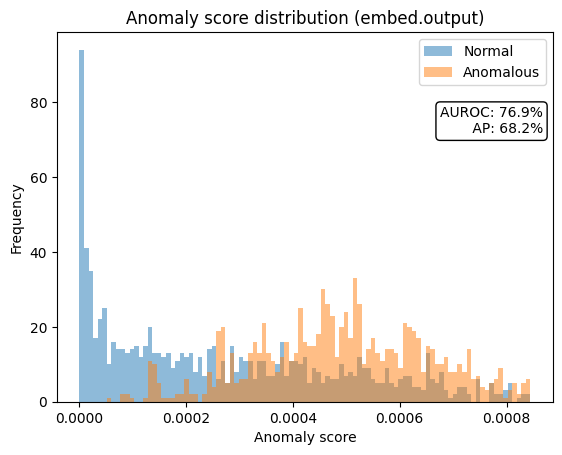

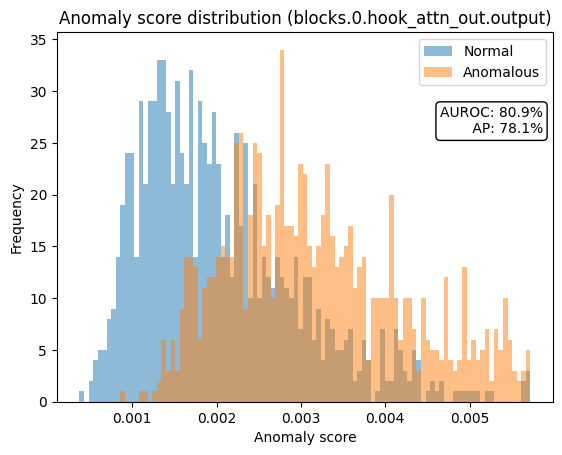

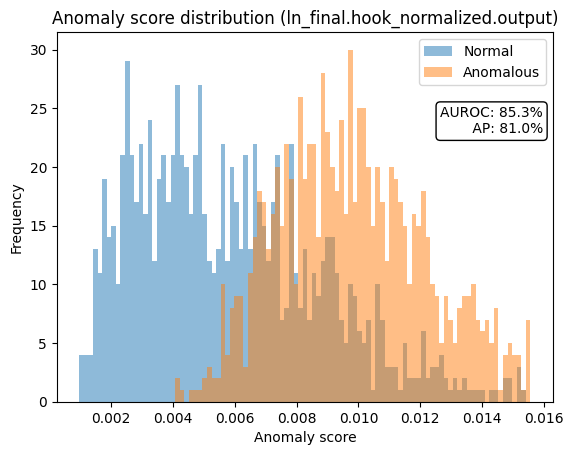

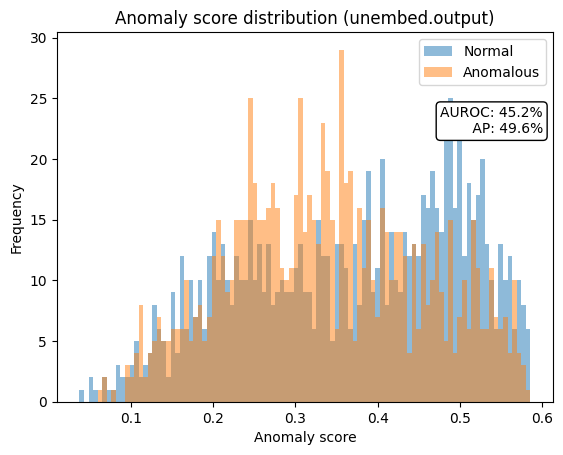

In [50]:
scripts.eval_detector(task, detector, save_path=None, batch_size=64, layerwise=True)

In [86]:
for idx in range(20):
    print(task.model.tokenizer.decode(task_config["train"][idx]["prefix_tokens"]))
    print(task.model.tokenizer.decode(task_config["train"][idx]["completion_token"]))
    print(task_config["train"][idx]["effect_prob"])
    print("=" * 80)

d9b0-bd81-4108-be7
4
0.7943361401557922
 []

        if self.key.encode('hex_codec')!= '9
6
0.5116864442825317
 simple_HashTable.hash('123456789
0
0.8805338740348816
 directory into path
>>>>>>> e372e19b0a
5
0.712540864944458
restplus/commit/0d95bcacdc5d34
7
0.8392882347106934
ips[1]['ip_address'], '2607:f0
d
0.7220106720924377
['_id']), '497ce96f395
f
0.9114751815795898

#
#  Generated from FHIR 4.0.0-a
5
0.32148584723472595
_KEY = '2b532992c842
4
0.8680476546287537
publican-news?ID=dab97fc4-2e
1
0.7761212587356567
')
        data = {
            'old_password': 'password@abc1
2
0.8875949382781982
6 <http://www.ietf.org/rfc/rfc
4
0.817144513130188
(__file__)
        return os.path.join(basedir, "5
8
0.15761394798755646
KFkPQFquQaUCgYB2fc43
1
0.6244156956672668
.make_can_msg("SCC12", 0, scc
1
0.3287602365016937
.github.com/DenisFromHR/cc86337
5
0.5933372378349304
pubid=ra-4f7088a56bb9
3
0.8867841362953186
. DOI: 10.1097/PHM.0b
0
0.3822169303894043
 file size to the server.
        if n

In [83]:
task_config["train"][0]

{'prefix_tokens': [70,
  27,
  68,
  18,
  15,
  14426,
  26,
  19,
  15,
  22,
  19,
  18,
  26,
  15,
  1234,
  25],
 'completion_token': 22,
 'effect_prob': 0.7943361401557922,
 'clean_effect_prob': 0.7821500301361084}

In [80]:
for name, param in detector.model.named_parameters():
    print(name, param.device)

embed.W_E cpu
pos_embed.W_pos cpu
blocks.0.ln1.w cpu
blocks.0.ln1.b cpu
blocks.0.attn.W_Q cpu
blocks.0.attn.W_O cpu
blocks.0.attn.b_Q cpu
blocks.0.attn.b_O cpu
blocks.0.attn.W_K cpu
blocks.0.attn.W_V cpu
blocks.0.attn.b_K cpu
blocks.0.attn.b_V cpu
ln_final.w cpu
ln_final.b cpu
unembed.W_U cpu
unembed.b_U cpu


In [78]:
next(task.model.parameters()).device

device(type='cpu')

In [79]:
for name, _ in detector.model.named_modules():
    print(name)


embed
hook_embed
pos_embed
hook_pos_embed
blocks
blocks.0
blocks.0.ln1
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.attn
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_post
ln_final
ln_final.hook_scale
ln_final.hook_normalized
unembed
